In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
import omnivida_loader as ov
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Let's start by loading the cleansed datasets into pandas DataFrames. 

In [3]:
adherence, adherence_change = ov.get_adherence_dataset()
basic_info = ov.get_basic_info_dataset()

### Basic personal data

In [4]:
basic_info.head()

,id_patient,age,gender,education,civil_status,department,city,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate
0,500547,58.0,M,SECUNDARIA,CASADO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19
1,500588,15.0,M,PRIMARIA,SOLTERO (A),CUNDINAMARCA,BOGOTA,2.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19
2,502989,29.0,M,UNIVERSITARIO,SOLTERO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22
3,506808,11.0,M,EDAD PREESCOLAR,SOLTERO (A),ANTIOQUIA,BELLO,1.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06
4,512938,22.0,F,SECUNDARIA,SOLTERO (A),ANTIOQUIA,MEDELLIN,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15


In [5]:
list(basic_info.socioeconomic_level.unique())

['A',
 'B',
 'NIVEL 0 DEL SISBEN',
 'NIVEL 1 DEL SISBEN',
 'C',
 nan,
 'NIVEL 2 DEL SISBEN']

In [6]:
basic_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 15 columns):
id_patient                          872 non-null int64
age                                 872 non-null float64
gender                              870 non-null category
education                           862 non-null category
civil_status                        872 non-null category
department                          872 non-null object
city                                872 non-null object
social_stratum                      872 non-null float64
zone                                872 non-null category
socioeconomic_level                 860 non-null category
occupation                          872 non-null category
social_security_regime              850 non-null category
social_security_affiliation_type    850 non-null category
employment_type                     852 non-null category
birthdate                           872 non-null datetime64[ns]
dtypes: category(9), datetim

In [7]:
basic_info.describe(include='all')

,id_patient,age,gender,education,civil_status,department,city,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate
count,8.720000e+02,872.000000,870,862,872,872,872,872.000000,872,860,872,850,850,852,872
unique,NaN,NaN,2,8,6,10,52,NaN,2,6,8,4,3,5,858
top,NaN,NaN,F,SECUNDARIA,SOLTERO (A),ANTIOQUIA,MEDELLIN,NaN,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1984-05-28 00:00:00
freq,NaN,NaN,604,384,410,699,464,NaN,839,629,457,826,532,471,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1932-04-05 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-04 00:00:00
mean,1.259526e+06,41.146789,NaN,NaN,NaN,NaN,NaN,2.983945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.343817e+05,18.222354,NaN,NaN,NaN,NaN,NaN,0.865047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.005470e+05,5.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.887368e+05,27.000000,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's define a new variable called `grupo_edad` (age group), to process age as a categorial variable:

In [8]:
basic_info['age_group'] = basic_info['age'].apply(lambda x: np.ceil(x/10.))

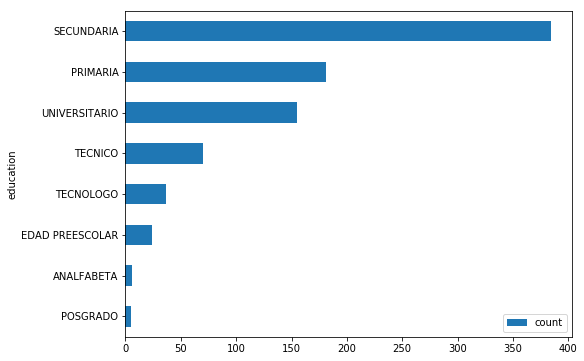

In [9]:
escolaridad = basic_info[['id_patient', 'education']].groupby('education').size().sort_values(ascending=False).reset_index(name='count')
escolaridad.sort_values(by='count', ascending=True).plot(kind='barh', x='education', figsize=(8,6))

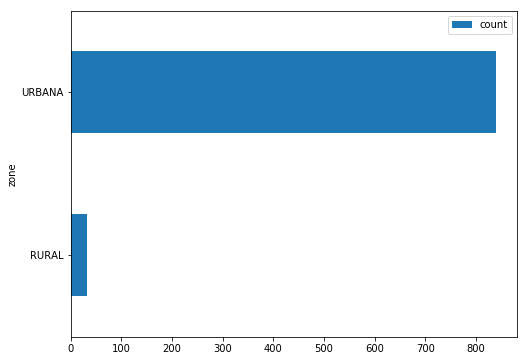

In [10]:
zona = basic_info[['id_patient', 'zone']].groupby('zone').size().sort_values(ascending=False).reset_index(name='count')
zona.sort_values(by='count', ascending=True).plot(kind='barh', x='zone', figsize=(8,6))

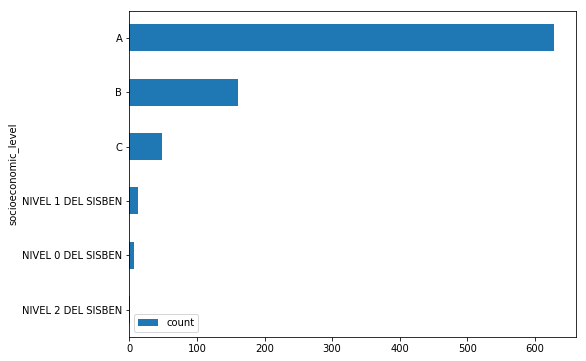

In [11]:
nivel_socioeconomico = basic_info[['id_patient', 'socioeconomic_level']].groupby('socioeconomic_level').size().sort_values(ascending=False).reset_index(name='count')
nivel_socioeconomico.sort_values(by='count', ascending=True).plot(kind='barh', x='socioeconomic_level', figsize=(8,6))

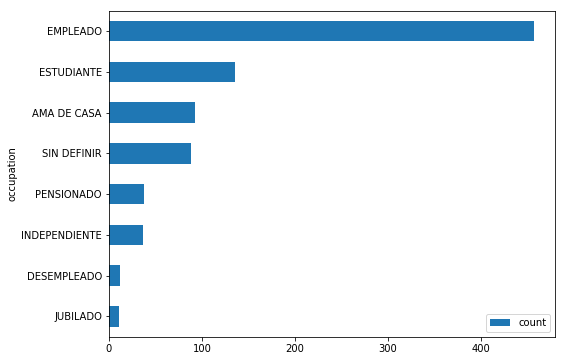

In [12]:
ocupacion = basic_info[['id_patient', 'occupation']].groupby('occupation').size().sort_values(ascending=False).reset_index(name='count')
ocupacion.sort_values(by='count', ascending=True).plot(kind='barh', x='occupation', figsize=(8,6))

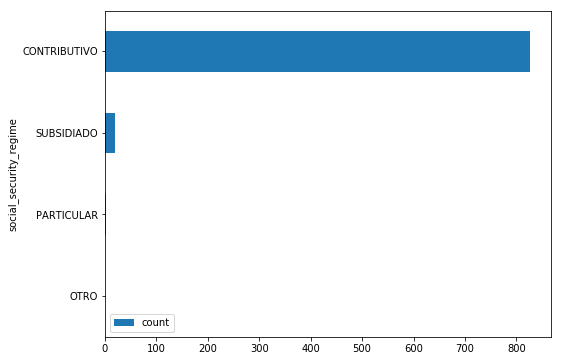

In [13]:
regimen = basic_info[['id_patient', 'social_security_regime']].groupby('social_security_regime').size().sort_values(ascending=False).reset_index(name='count')
regimen.sort_values(by='count', ascending=True).plot(kind='barh', x='social_security_regime', figsize=(8,6))

In [14]:
adherence.head()

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
0,500547,2016-07-11,1,1,4,1,6.0,1,4,A
1,500547,2019-03-14,1,1,4,1,6.0,1,4,A
2,500547,2019-10-11,1,1,4,1,6.0,1,4,A
3,500547,2019-12-09,1,1,4,1,6.0,1,4,A
4,500547,2020-01-16,1,1,4,1,6.0,1,4,A


In [15]:
adherence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 10 columns):
id_patient             4773 non-null int64
survey_date            4773 non-null datetime64[ns]
morisky_green          4773 non-null int64
smaq1                  4773 non-null int64
smaq2                  4773 non-null int64
espa                   4773 non-null int64
nm_espa                4773 non-null float64
qualitative_result     4773 non-null int64
quantitative_result    4773 non-null int64
category               4773 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), int64(7)
memory usage: 340.5 KB


In [16]:
adherence.describe(include='all')

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
count,4.773000e+03,4773,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773
unique,NaN,1433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,2019-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2317
first,NaN,2012-04-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.238178e+06,NaN,0.848942,0.836162,3.774356,0.830086,5.602975,0.793002,3.774356,NaN
std,4.296392e+05,NaN,0.358143,0.370168,0.799201,0.375597,0.911489,0.405196,0.799201,NaN
min,5.005470e+05,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,8.716330e+05,NaN,1.000000,1.000000,4.000000,1.000000,5.000000,1.000000,4.000000,NaN


,id_patient,count_records
0,1769865,41
1,979605,30
2,1132214,28
3,622031,27
4,1676414,26
5,1196034,25
6,916510,25
7,1536265,23
8,1828862,23
9,1399081,23


4773


Text(0.5,1,'Number of adherence records per patient')

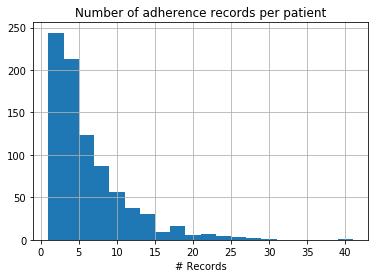

In [17]:
num_records_per_patient = adherence.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_patient.head(10))
print(sum(num_records_per_patient['count_records']))
num_records_per_patient.hist('count_records', bins=20)
plt.xlabel('# Records')
plt.title('Number of adherence records per patient')

,category,count_records
0,A,2317
1,M,1285
2,A-,689
3,N+,472
4,N,10


4773


Text(0.5,1,'Number records per category')

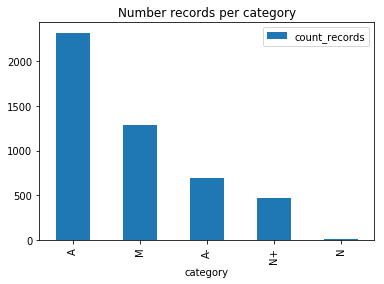

In [18]:
num_records_per_category = adherence.groupby('category').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_category)
print(sum(num_records_per_category['count_records']))
num_records_per_category.plot(kind='bar', x='category')
# plt.xlabel('# Records')
plt.title('Number records per category')

In [20]:
adherence_pivot = adherence.copy()
adherence_pivot['survey_month'] = adherence_pivot['survey_date'].dt.month
adherence_pivot['survey_year'] = adherence_pivot['survey_date'].dt.year
adherence_pivot_cuantitativo = pd.pivot_table(adherence_pivot, values='quantitative_result', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_cualitativo = pd.pivot_table(adherence_pivot, values='qualitative_result', index='survey_month', columns='survey_year', aggfunc='sum')
adherence_pivot_enrevistas = pd.pivot_table(adherence_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

Text(0.5,1,'Reportes de adherencia')

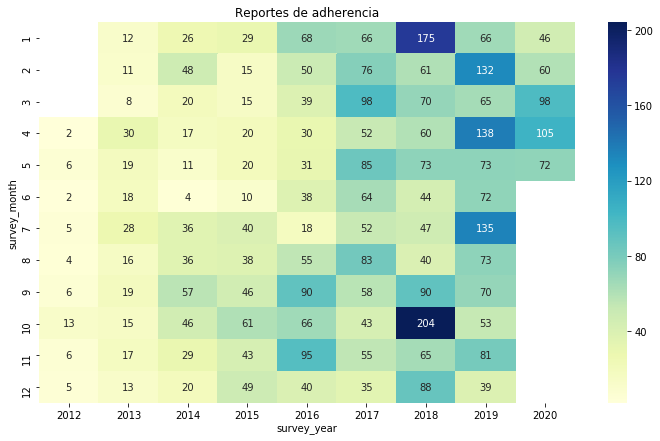

In [21]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_enrevistas, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Reportes de adherencia')

Text(0.5,1,'Number of adherent patients per month')

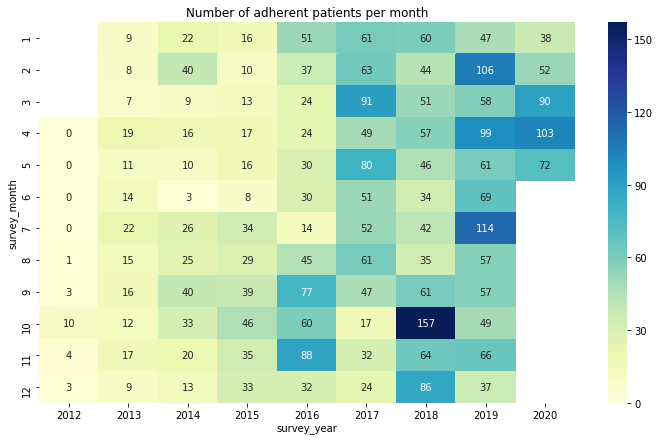

In [22]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cualitativo, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Number of adherent patients per month')

Text(0.5,1,'Percentage of adherent patients per month')

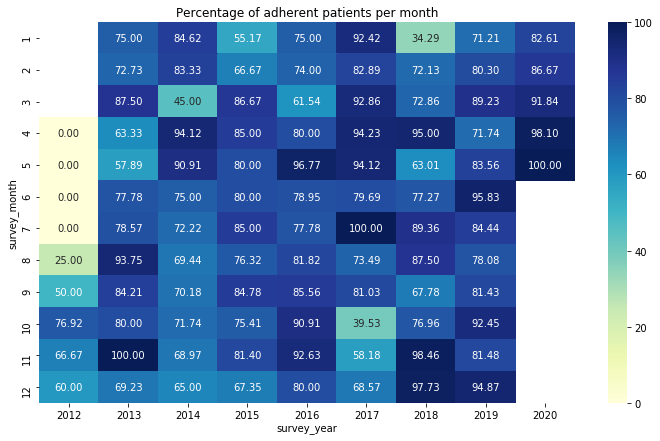

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(100*(adherence_pivot_cualitativo/adherence_pivot_enrevistas), ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Percentage of adherent patients per month')

Text(0.5,1,'Average adherence score per month')

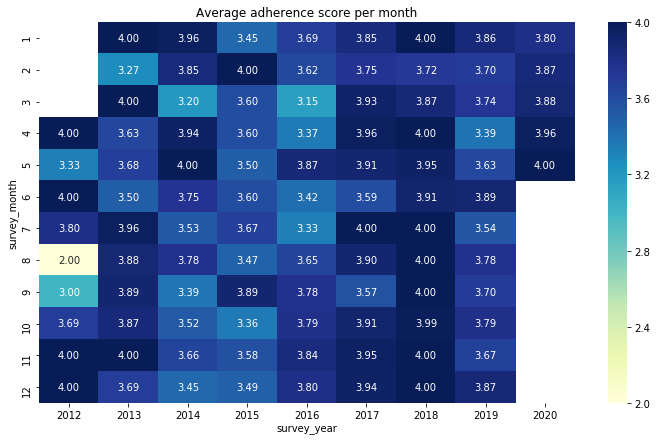

In [24]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cuantitativo, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Average adherence score per month')

Text(0.5,1,'Median adherence (qualitative) score per month')

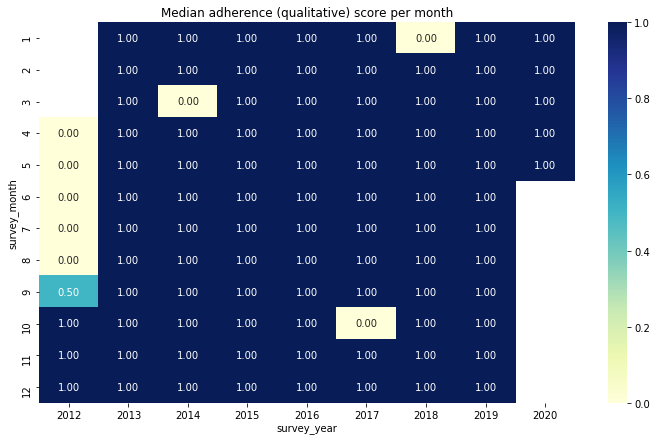

In [27]:
adherence_pivot_cualitativo2 = pd.pivot_table(adherence_pivot, values='qualitative_result', index='survey_month', columns='survey_year', aggfunc='median')
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_cualitativo2, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Median adherence (qualitative) score per month')

In [28]:
adherence_change.head(10)

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category,morisky_change,smaq1_change,smaq2_change,espa_change,nm_espa_change,qualitative_result_change,quantitative_result_change,days_since_last_control,num_reports,ongoing_adherence_percentage
0,500547,2016-07-11,1,1,4,1,6.0,1,4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
1,500547,2019-03-14,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,2,100.0
2,500547,2019-10-11,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0,3,100.0
3,500547,2019-12-09,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,4,100.0
4,500547,2020-01-16,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,5,100.0
5,500547,2020-03-25,1,1,4,1,6.0,1,4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,6,100.0
6,500547,2020-05-08,1,1,4,1,5.0,1,4,A,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,44.0,7,100.0
7,500588,2019-04-26,1,1,4,1,6.0,1,4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
8,502989,2014-08-22,0,0,2,1,5.0,0,2,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
9,502989,2014-10-28,0,0,2,0,5.0,0,2,M,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,67.0,2,0.0


In [29]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'quantitative_result', 'qualitative_result_change', 'quantitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,1
1,500547,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,2
2,500547,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,3
3,500547,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,4
4,500547,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,5
5,500547,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,6
6,500547,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,7
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,1
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,1
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,2


In [30]:
adherence_change_analysis_pivot = adherence_change_analysis.copy()
adherence_change_analysis_pivot['survey_month'] = adherence_change_analysis_pivot['survey_date'].dt.month
adherence_change_analysis_pivot['survey_year'] = adherence_change_analysis_pivot['survey_date'].dt.year
adherence_pivot_dias_control = pd.pivot_table(adherence_change_analysis_pivot, values='days_since_last_control', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_adher_percentage = pd.pivot_table(adherence_change_analysis_pivot, values='ongoing_adherence_percentage', index='survey_month', columns='survey_year', aggfunc='mean')

Text(0.5,1,'Dias desde el ultimo control')

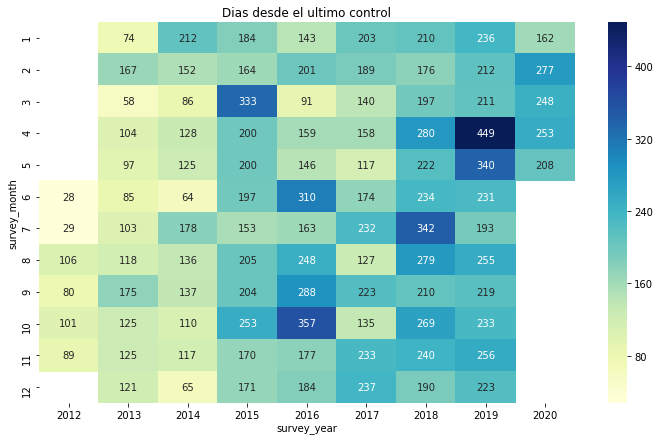

In [31]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_dias_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Dias desde el ultimo control')

Text(0.5,1,'Porcentage de adherencia historico promedio por mes')

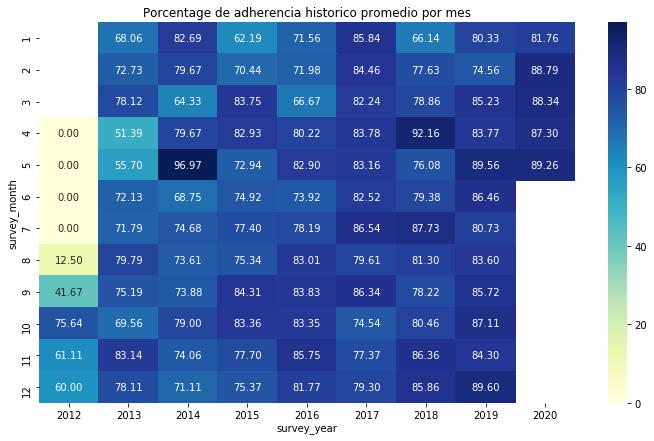

In [32]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_adher_percentage, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Porcentage de adherencia historico promedio por mes')

#### Let's have a look at those patients that went from `adherent` (i.e. 1 in the `cualitativo_ponderado` field) to `non-adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [33]:
adherence_change_analysis.head(20)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,1
1,500547,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,2
2,500547,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,3
3,500547,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,4
4,500547,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,5
5,500547,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,6
6,500547,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,7
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,1
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,1
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,2


In [34]:
neg_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==-1]
neg_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
14,502989,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29,7
16,502989,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22,9
20,502989,2018-10-03,M,0,4,-1.0,0.0,421.0,38.46,13
35,506808,2018-10-08,M,0,4,-1.0,0.0,131.0,85.71,14
44,512938,2018-05-04,M,0,4,-1.0,0.0,216.0,85.71,7
48,512938,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73,11
51,514102,2018-01-30,A,0,4,-1.0,0.0,74.0,66.67,3
55,524006,2015-10-13,A-,0,4,-1.0,0.0,33.0,66.67,3
62,524006,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00,10
93,529410,2018-01-30,A-,0,4,-1.0,0.0,122.0,66.67,6


In [35]:
neg_transition_count = neg_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_neg_transitions')
neg_transition_count.head(10)

,id_patient,count_neg_transitions
0,1769865,7
1,832593,7
2,622031,6
3,739693,6
4,673765,6
5,916510,6
6,1828862,5
7,1132214,5
8,747471,5
9,801004,5


Text(0.5,1,'Number of negative transitions per month')

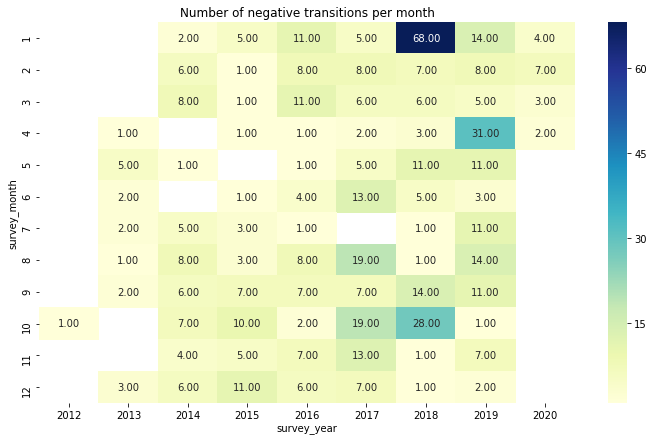

In [36]:
neg_transition_pivot = neg_transition.copy()
neg_transition_pivot['survey_month'] = neg_transition_pivot['survey_date'].dt.month
neg_transition_pivot['survey_year'] = neg_transition_pivot['survey_date'].dt.year
neg_transition_pivot = pd.pivot_table(neg_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(neg_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of negative transitions per month')

#### Let's have a look at those patients that went from `non-adherent` (i.e. 0 in the `cualitativo_ponderado` field) to `adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [37]:
pos_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==1]
pos_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
13,502989,2015-06-25,M,1,4,1.0,1.0,162.0,16.67,6
15,502989,2016-01-15,M,1,4,1.0,1.0,3.0,25.00,8
17,502989,2017-03-21,M,1,4,1.0,1.0,77.0,30.00,10
21,502989,2019-02-08,M,1,4,1.0,0.0,128.0,42.86,14
23,506808,2013-05-24,M,1,4,1.0,0.0,16.0,50.00,2
37,506808,2019-06-14,M,1,4,1.0,4.0,113.0,81.25,16
46,512938,2018-11-14,M,1,4,1.0,0.0,42.0,77.78,9
52,514102,2018-09-25,A,1,4,1.0,0.0,238.0,75.00,4
57,524006,2016-06-02,A-,1,4,1.0,0.0,206.0,60.00,5
63,524006,2017-07-28,A-,1,4,1.0,1.0,79.0,72.73,11


In [38]:
pos_transition_count = pos_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_pos_transitions')
pos_transition_count.head(10)

,id_patient,count_pos_transitions
0,1769865,8
1,832593,7
2,622031,7
3,673765,6
4,739693,6
5,1132214,6
6,747471,5
7,1399081,5
8,916510,5
9,801004,5


Text(0.5,1,'Number of positive transitions per month')

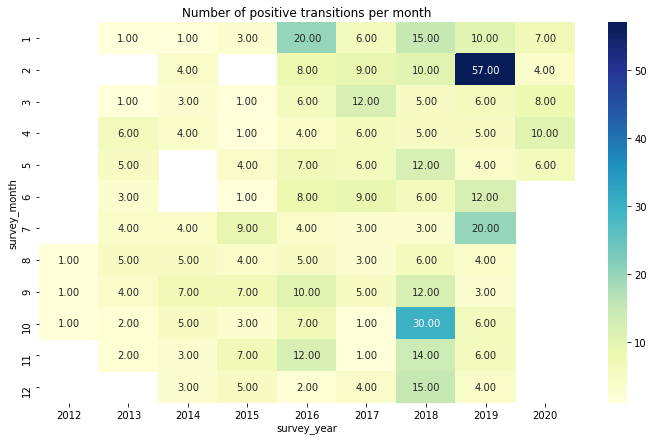

In [39]:
pos_transition_pivot = pos_transition.copy()
pos_transition_pivot['survey_month'] = pos_transition_pivot['survey_date'].dt.month
pos_transition_pivot['survey_year'] = pos_transition_pivot['survey_date'].dt.year
pos_transition_pivot = pd.pivot_table(pos_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(pos_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of positive transitions per month')

#### Let's study the influence of some demographic factors on the adherence (age, education, gender, socioeconomic status, zone, employment type)

In [40]:
basic_info_adherence = adherence_change_analysis.merge(basic_info, how='left', on='id_patient')
basic_info_adherence['category'] = basic_info_adherence['category'].astype('category')
basic_info_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
basic_info_adherence['age_at_survey_date'] = (np.ceil((basic_info_adherence['survey_date'] - basic_info_adherence['birthdate']) / np.timedelta64(1, 'Y'))).astype(int)

In [41]:
basic_info_adherence.head(20)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,1,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,55
1,500547,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,2,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,57
2,500547,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,3,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
3,500547,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,4,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
4,500547,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,5,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
5,500547,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,6,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
6,500547,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,7,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,1,...,2.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19,2.0,15
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,1,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25


1. Adherence vs. Age

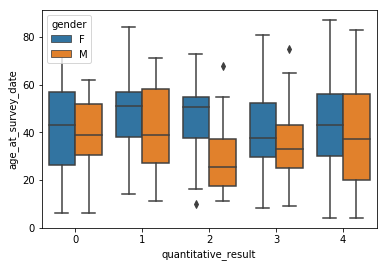

In [43]:
sns.boxplot(data=basic_info_adherence, x='quantitative_result', y='age_at_survey_date', hue='gender')

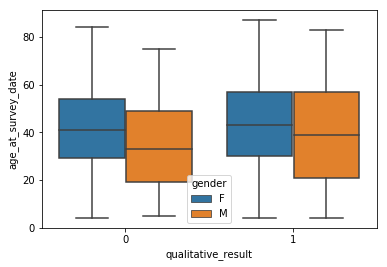

In [44]:
sns.boxplot(data=basic_info_adherence, x='qualitative_result', y='age_at_survey_date', hue='gender')

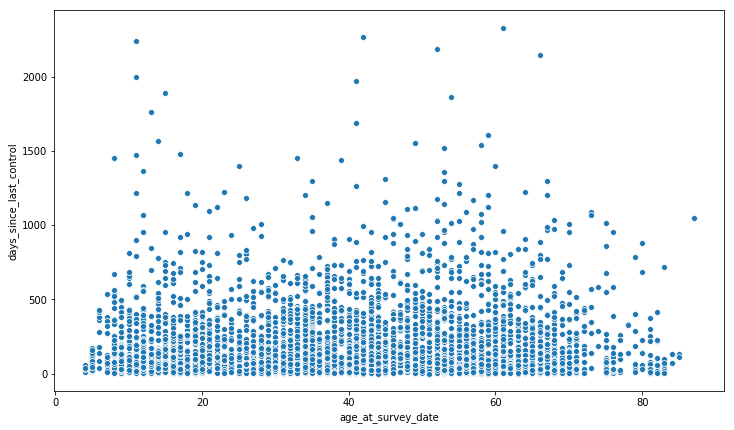

In [45]:
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(data=basic_info_adherence, x='age_at_survey_date', y='days_since_last_control', ax=ax)

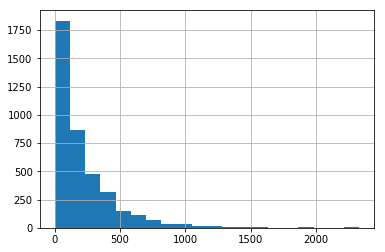

In [106]:
basic_info_adherence['days_since_last_control'].hist(bins=20)

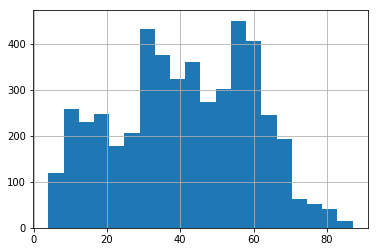

In [46]:
basic_info_adherence['age_at_survey_date'].hist(bins=20)

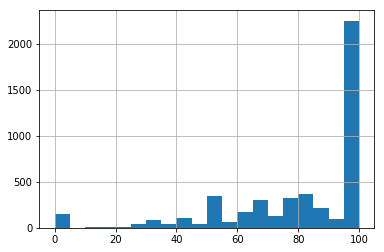

In [47]:
basic_info_adherence['ongoing_adherence_percentage'].hist(bins=20)

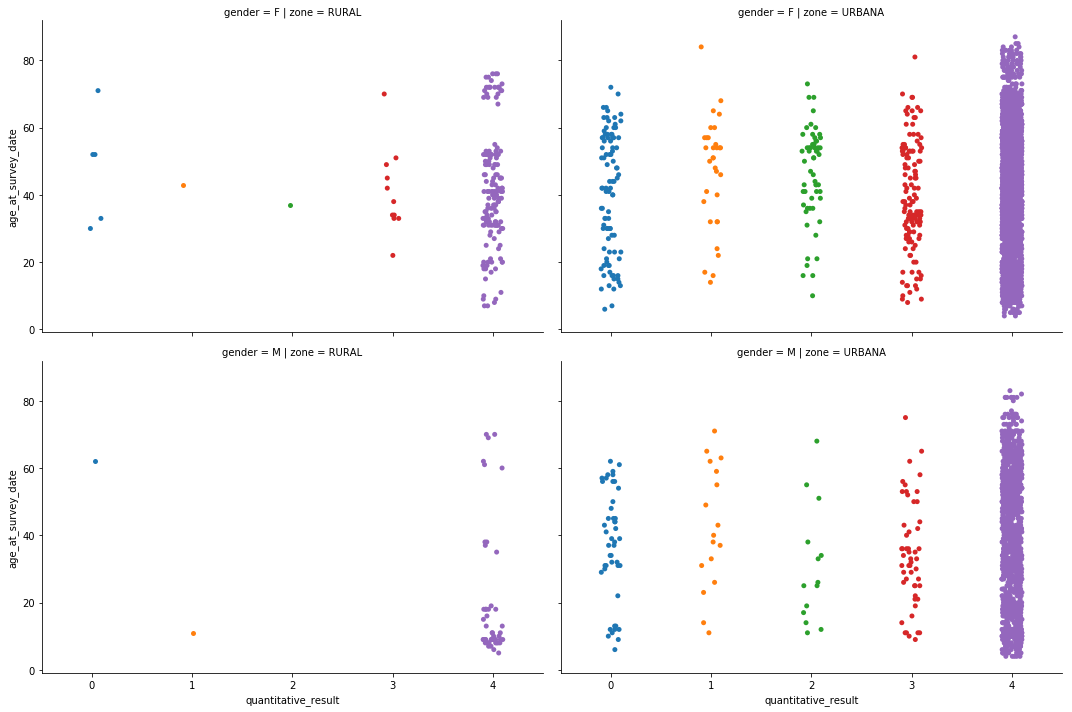

In [49]:
sns.catplot(data=basic_info_adherence, y="age_at_survey_date", x="quantitative_result", col='zone', row='gender',
            height=5, aspect=1.5)

Text(0.5,1,'Age vs Adherence category')

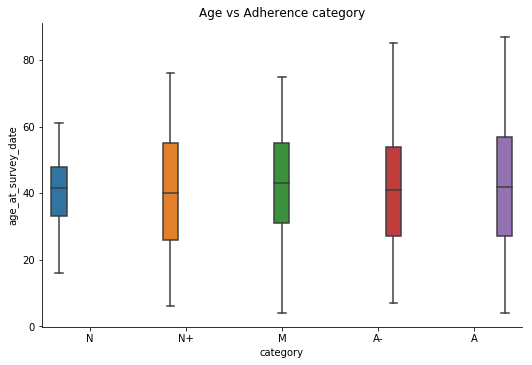

In [50]:
sns.catplot(data=basic_info_adherence, y="age_at_survey_date", x="category", hue="category",#, col='zona', row='genero',
            kind='box', height=5, aspect=1.5)
plt.title("Age vs Adherence category")

In [51]:
basic_info_adherence[['category', 'num_reports', 'days_since_last_control']].loc[basic_info_adherence['category']=='N']

,category,num_reports,days_since_last_control
1052,N,1,NaN
1774,N,1,NaN
1881,N,1,NaN
2579,N,1,NaN
3572,N,1,NaN
4105,N,1,NaN
4483,N,1,NaN
4520,N,1,NaN
4706,N,1,NaN
4707,N,2,50.0


In [53]:
basic_info_adherence[['category', 'ongoing_adherence_percentage', 'num_reports', 'days_since_last_control']].groupby('category').agg(['mean', 'std', 'count'])

ongoing_adherence_percentage                  num_reports            \
                                 mean        std count        mean       std   
category                                                                       
N                            0.000000   0.000000    10    1.100000  0.316228   
N+                          58.971314  26.513999   472    8.156780  7.628642   
M                           70.331805  26.563203  1285    6.893385  5.088653   
A-                          75.964790  20.108902   689    6.898403  5.191799   
A                           91.305373  18.516853  2317    3.776435  3.149978   

               days_since_last_control                    
         count                    mean         std count  
category                                                  
N           10               50.000000         NaN     1  
N+         472              177.475962  239.614167   416  
M         1285              188.763319  224.042529  1145  
A-         689              174.493590  182.450415   624  
A         2317              252.566686  280.667504  1747

In [54]:
basic_info_adherence[['qualitative_result', 'ongoing_adherence_percentage', 'num_reports', 'days_since_last_control']].groupby('qualitative_result').agg(['mean', 'std', 'count'])

ongoing_adherence_percentage                  num_reports  \
                                           mean        std count        mean   
qualitative_result                                                             
0                                     49.427186  26.182783   988    6.518219   
1                                     88.050478  17.540239  3785    5.226420   

                                   days_since_last_control                    
                         std count                    mean         std count  
qualitative_result                                                            
0                   5.295586   988              192.104308  219.561581   882  
1                   4.807306  3785              219.828253  256.978061  3051

In [55]:
from scipy import stats

dias_pacientes_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 1].days_since_last_control
dias_pacientes_no_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 0].days_since_last_control

statistic, pvalue = stats.ttest_ind(dias_pacientes_adherentes,dias_pacientes_no_adherentes, equal_var=False, nan_policy='omit')
statistic, pvalue

(3.1738672340734504, 0.0015320928417005449)

In [56]:
num_reportes_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 1].num_reports
num_reportes_no_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 0].num_reports

statistic, pvalue = stats.ttest_ind(num_reportes_adherentes,num_reportes_no_adherentes, equal_var=False, nan_policy='omit')
statistic, pvalue

(-6.9558610322064407, 5.3009687733299182e-12)

In [57]:
hist_porcentaje_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 1].ongoing_adherence_percentage
hist_porcentaje_no_adherentes = basic_info_adherence[basic_info_adherence.qualitative_result == 0].ongoing_adherence_percentage

statistic, pvalue = stats.ttest_ind(hist_porcentaje_adherentes,hist_porcentaje_no_adherentes, equal_var=False, nan_policy='omit')
statistic, pvalue

(43.868908555597869, 1.2670407261076876e-253)

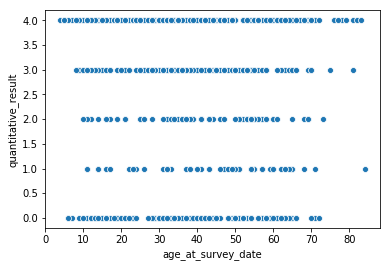

In [58]:
sns.scatterplot(x='age_at_survey_date', y='quantitative_result', data=basic_info_adherence[basic_info_adherence['qualitative_result']==0])

In [60]:
basic_info_non_adherent_patients = basic_info_adherence[(basic_info_adherence['quantitative_result'] < 4) & (basic_info_adherence['qualitative_result']==0)]
basic_info_non_adherent_patients

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,1,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
11,502989,2015-01-07,M,0,3,0.0,-1.0,47.0,0.00,4,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
12,502989,2015-01-14,M,0,3,0.0,0.0,7.0,0.00,5,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
14,502989,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29,7,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26
16,502989,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22,9,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,27
36,506808,2019-02-21,M,0,0,0.0,-4.0,136.0,80.00,15,...,1.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06,2.0,11
48,512938,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73,11,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15,3.0,22
62,524006,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00,10,...,3.0,URBANA,A,PENSIONADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1952-08-10,7.0,65
94,529410,2019-02-14,A-,0,3,0.0,-1.0,380.0,57.14,7,...,3.0,RURAL,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,1998-01-21,3.0,22


In [61]:
basic_info_adherent_patients = basic_info_adherence[(basic_info_adherence['quantitative_result'] == 4) & (basic_info_adherence['qualitative_result']==1)]
basic_info_adherent_patients

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
0,500547,2016-07-11,A,1,4,NaN,NaN,NaN,100.00,1,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,55
1,500547,2019-03-14,A,1,4,0.0,0.0,976.0,100.00,2,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,57
2,500547,2019-10-11,A,1,4,0.0,0.0,211.0,100.00,3,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
3,500547,2019-12-09,A,1,4,0.0,0.0,59.0,100.00,4,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
4,500547,2020-01-16,A,1,4,0.0,0.0,38.0,100.00,5,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
5,500547,2020-03-25,A,1,4,0.0,0.0,69.0,100.00,6,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
6,500547,2020-05-08,A,1,4,0.0,0.0,44.0,100.00,7,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,6.0,58
7,500588,2019-04-26,A,1,4,NaN,NaN,NaN,100.00,1,...,2.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-12-19,2.0,15
13,502989,2015-06-25,M,1,4,1.0,1.0,162.0,16.67,6,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
15,502989,2016-01-15,M,1,4,1.0,1.0,3.0,25.00,8,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26


In [63]:
adherence[adherence['id_patient']==1012279]

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
1666,1012279,2018-07-27,1,1,4,1,6.0,1,4,M
1667,1012279,2019-06-11,0,0,3,1,5.0,0,3,M
1668,1012279,2019-07-16,1,1,4,1,6.0,1,4,M
1669,1012279,2020-02-22,1,1,4,0,5.0,0,4,M


In [64]:
corr_basic_info_adherence = basic_info_adherence.loc[:, ~basic_info_adherence.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

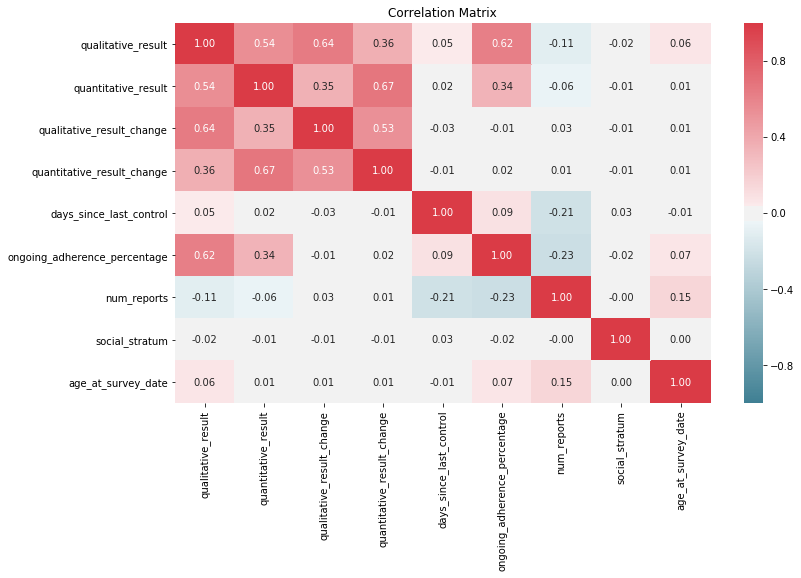

In [65]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_adherence, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [66]:
corr_basic_info_non_adherent = basic_info_non_adherent_patients.loc[:, ~basic_info_non_adherent_patients.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

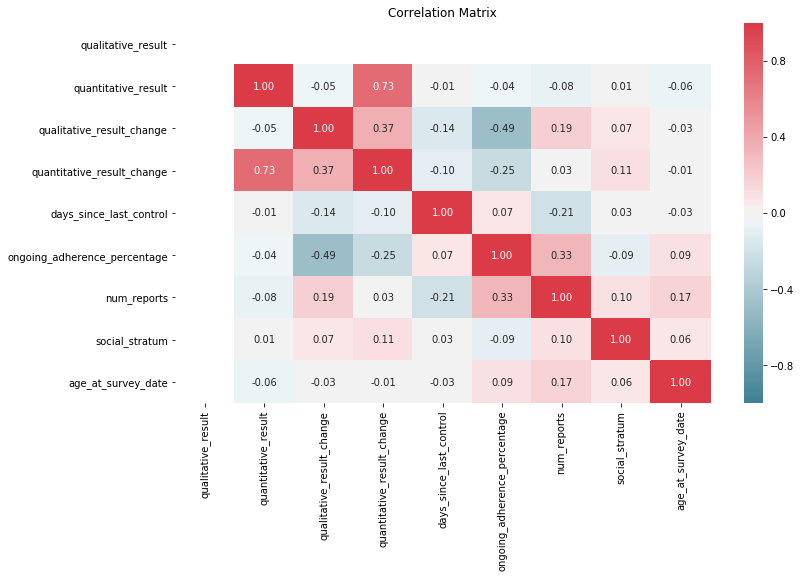

In [67]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_non_adherent, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [68]:
corr_basic_info_adherent_patients = basic_info_adherent_patients.loc[:, ~basic_info_adherent_patients.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

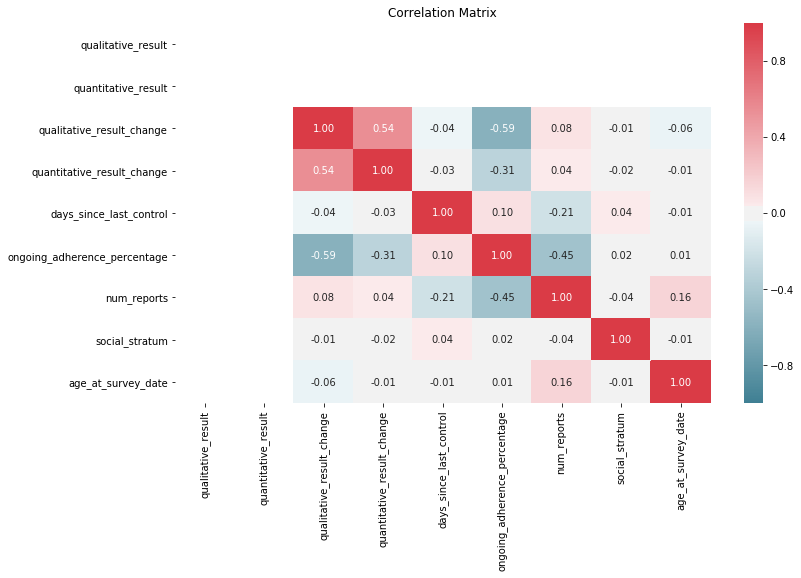

In [69]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_basic_info_adherent_patients, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


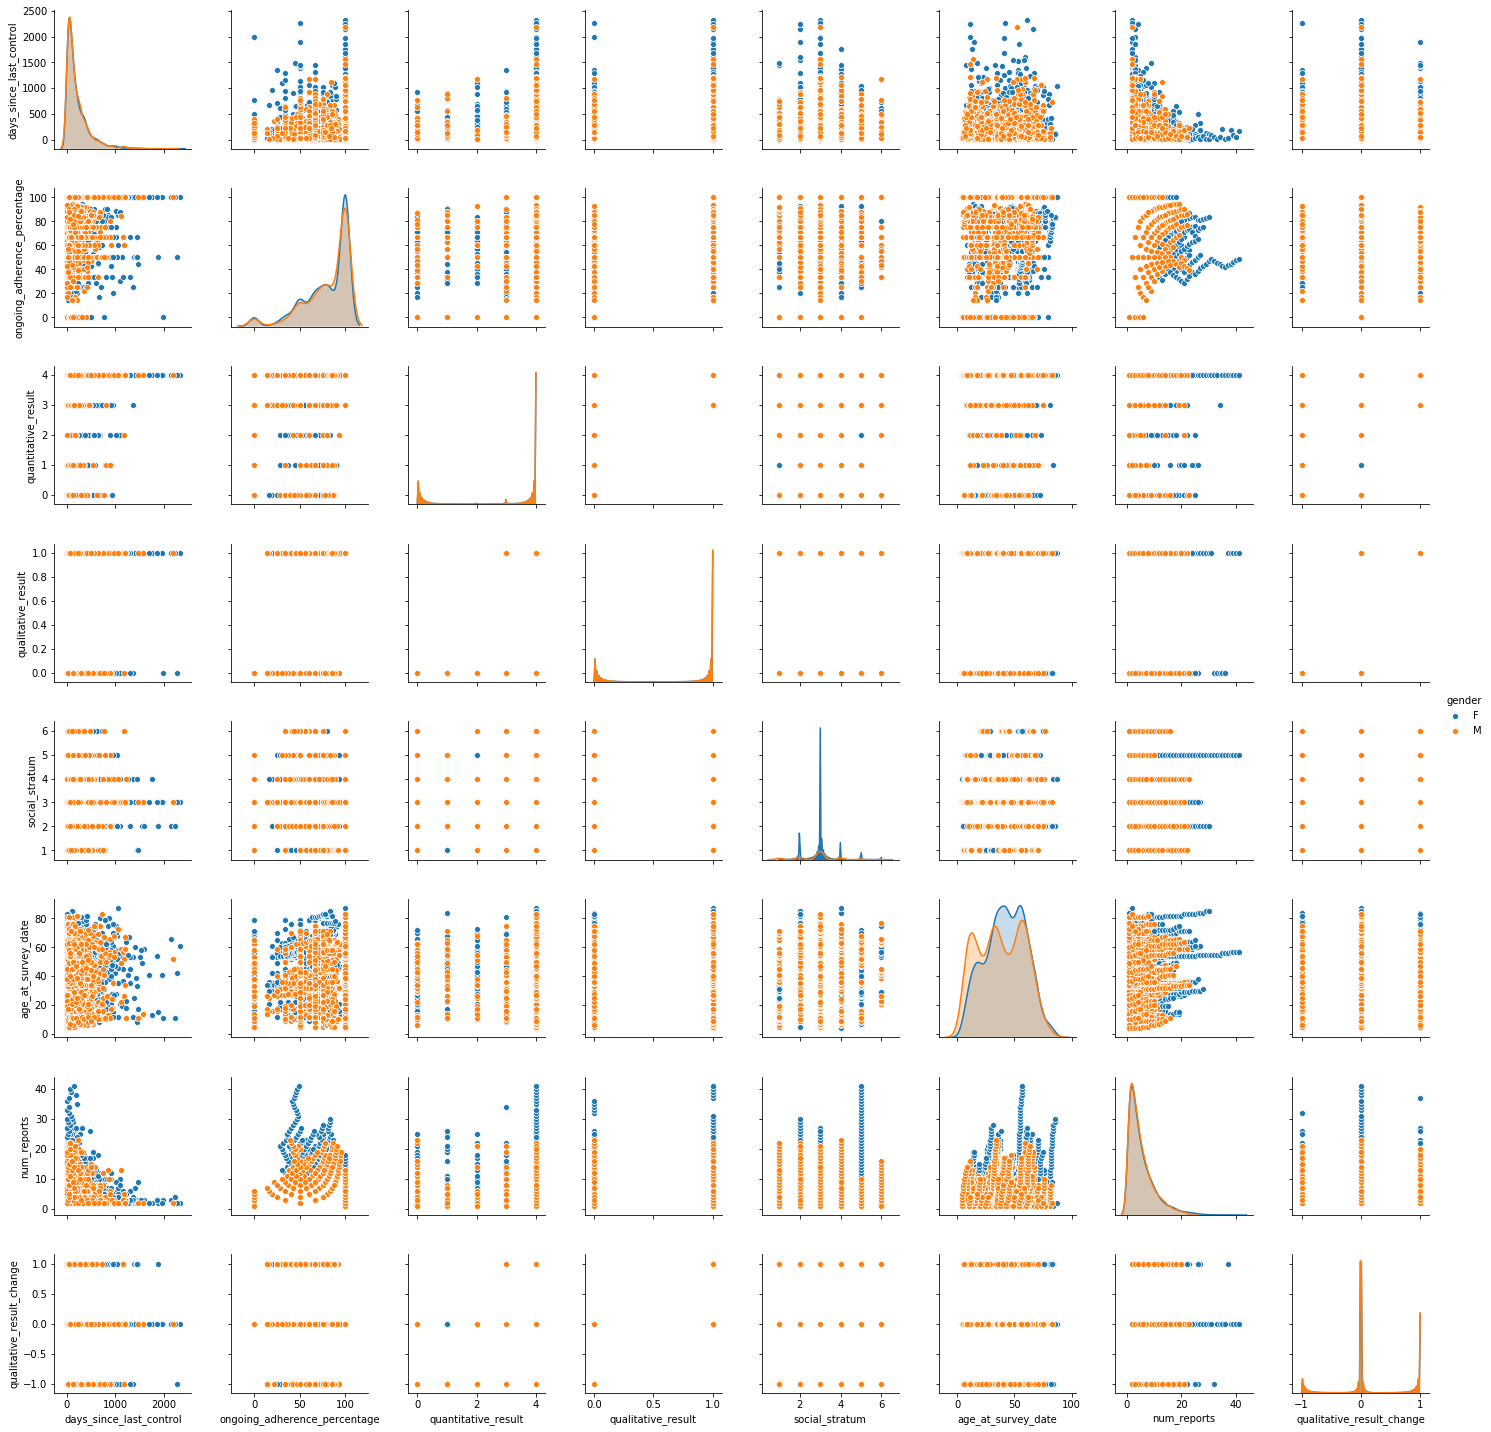

In [70]:
select_vars=['days_since_last_control', 'ongoing_adherence_percentage', 'quantitative_result', 'qualitative_result', 'social_stratum', 'age_at_survey_date', 'num_reports', 'qualitative_result_change']
sns.pairplot(basic_info_adherence, vars=select_vars, hue='gender', dropna=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


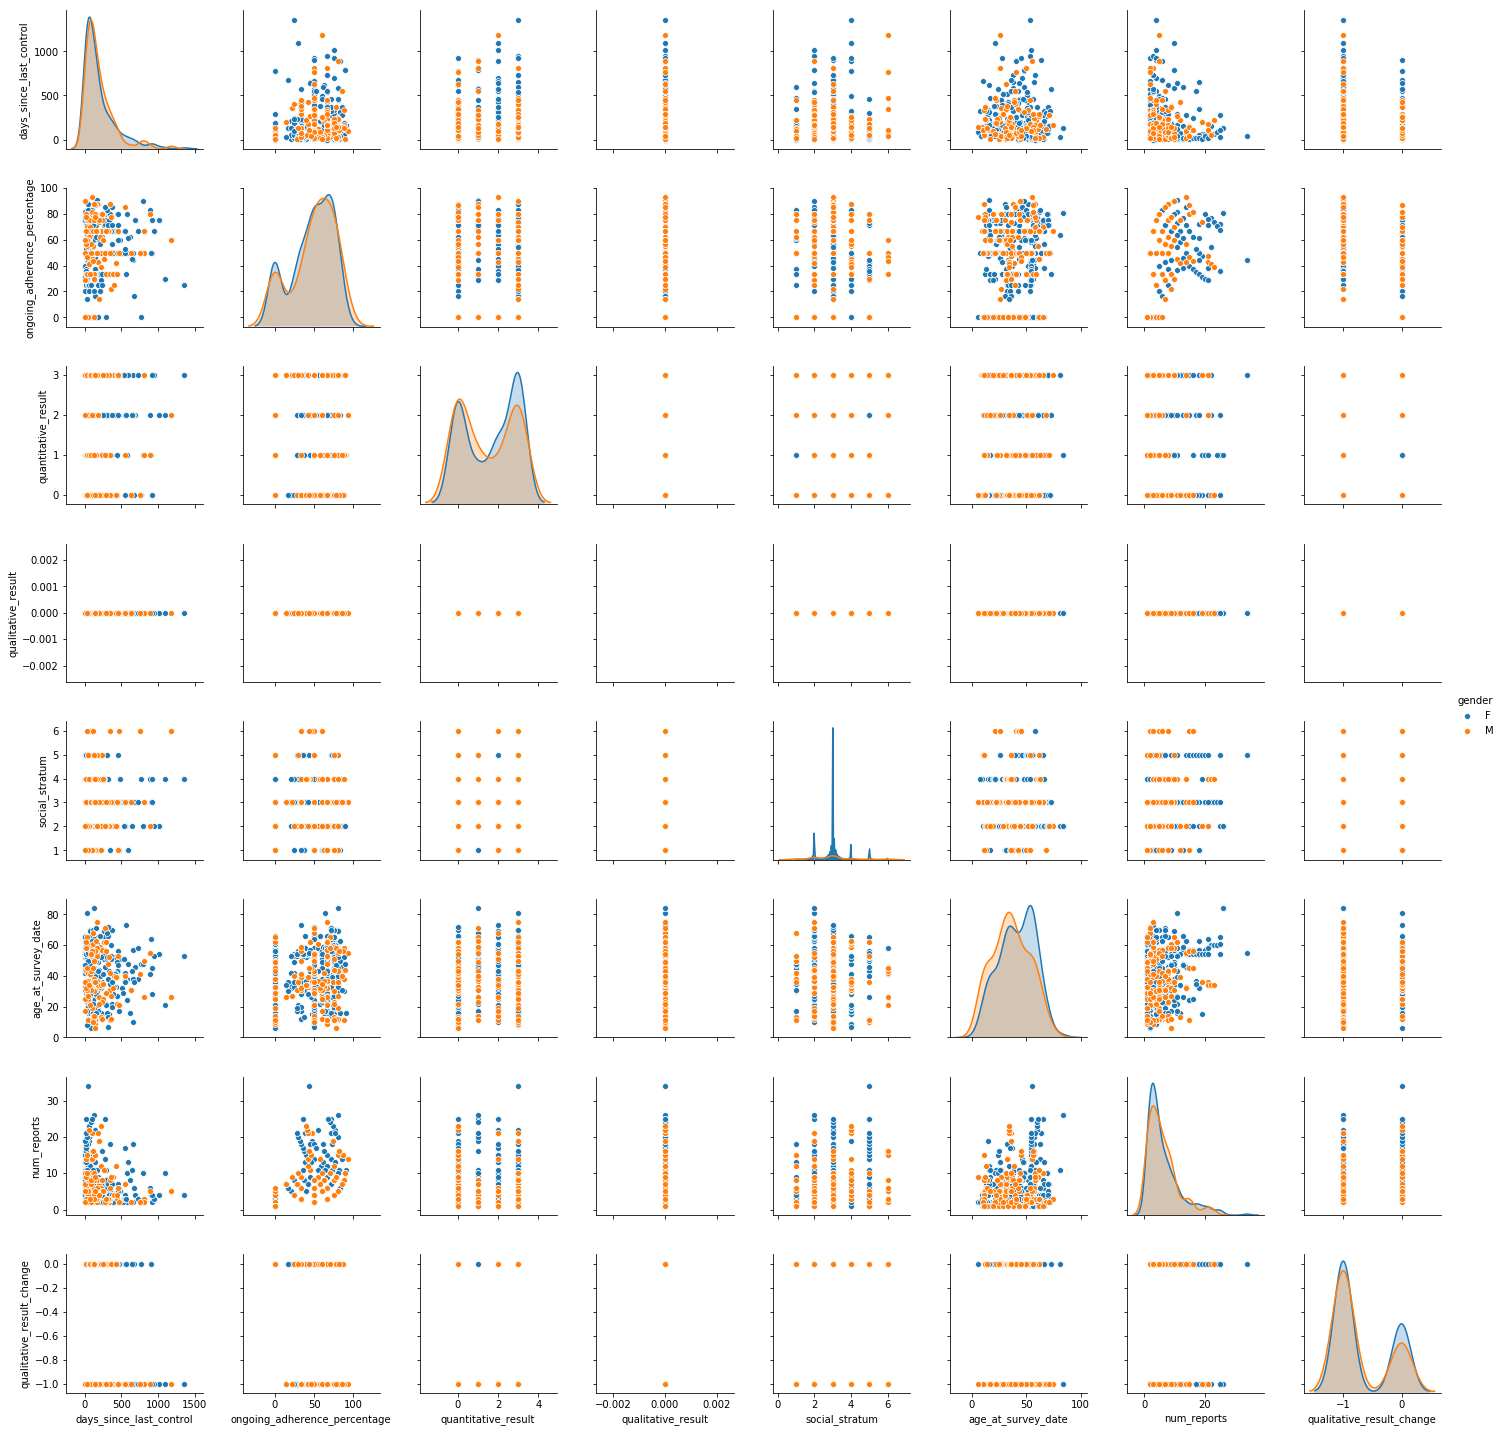

In [71]:
select_vars=['days_since_last_control', 'ongoing_adherence_percentage', 'quantitative_result', 'qualitative_result', 'social_stratum', 'age_at_survey_date', 'num_reports', 'qualitative_result_change']
sns.pairplot(basic_info_non_adherent_patients, vars=select_vars, hue='gender', dropna=True)

In [72]:
print(basic_info_adherent_patients.shape)
print(basic_info_non_adherent_patients.shape)


(3765, 26)
(442, 26)


In [73]:
balanced_sample = pd.concat([basic_info_adherent_patients.sample(basic_info_non_adherent_patients.shape[0]), basic_info_non_adherent_patients], ignore_index=True)

In [74]:
display(balanced_sample.head(10))
balanced_sample.shape

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
0,622031,2018-05-24,M,1,4,0.0,0.0,0.0,43.48,23,...,3.0,URBANA,A,AMA DE CASA,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1959-12-24,6.0,59
1,649629,2016-10-05,A,1,4,0.0,0.0,141.0,100.00,3,...,2.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1952-11-22,7.0,64
2,1441800,2017-05-31,A-,1,4,0.0,0.0,182.0,66.67,6,...,3.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2001-01-20,2.0,17
3,674247,2017-05-12,A,1,4,0.0,0.0,175.0,87.50,8,...,3.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1952-05-14,7.0,65
4,1997065,2014-12-11,M,1,4,0.0,0.0,56.0,100.00,4,...,3.0,URBANA,B,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2011-03-20,1.0,4
5,1439344,2019-06-20,A,1,4,0.0,0.0,266.0,100.00,2,...,3.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1954-10-23,7.0,65
6,1577730,2017-01-13,N+,1,4,0.0,0.0,79.0,75.00,8,...,3.0,URBANA,A,PENSIONADO,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1955-09-11,7.0,62
7,745494,2016-12-23,A-,1,4,0.0,0.0,612.0,100.00,2,...,4.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1984-07-25,4.0,33
8,1588635,2018-10-05,M,1,4,1.0,1.0,752.0,50.00,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2004-03-09,2.0,15
9,1071544,2019-05-24,A,1,4,0.0,0.0,550.0,100.00,3,...,6.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1990-10-08,3.0,29


(884, 26)

In [75]:
corr_balanced_sample = balanced_sample.loc[:, ~balanced_sample.columns.isin(['id_patient', 'age', 'age_group'])].corr()

Text(0.5,1,'Correlation Matrix')

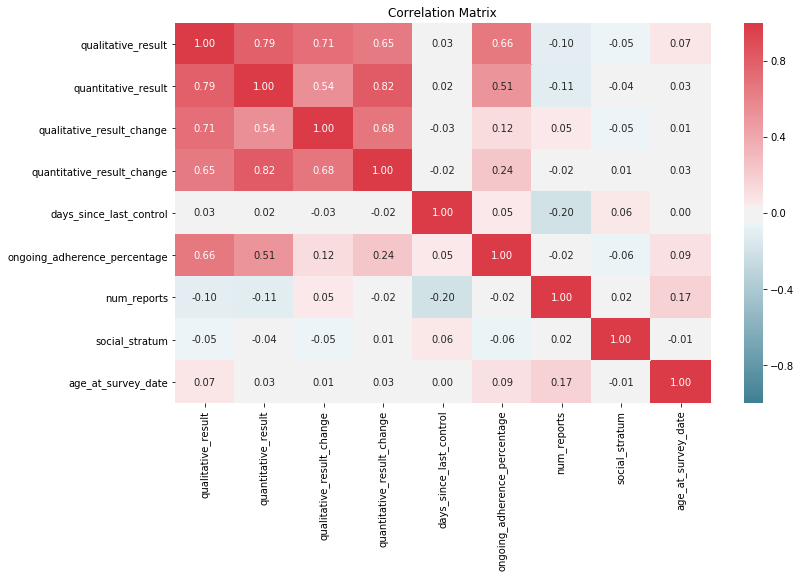

In [76]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_balanced_sample, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

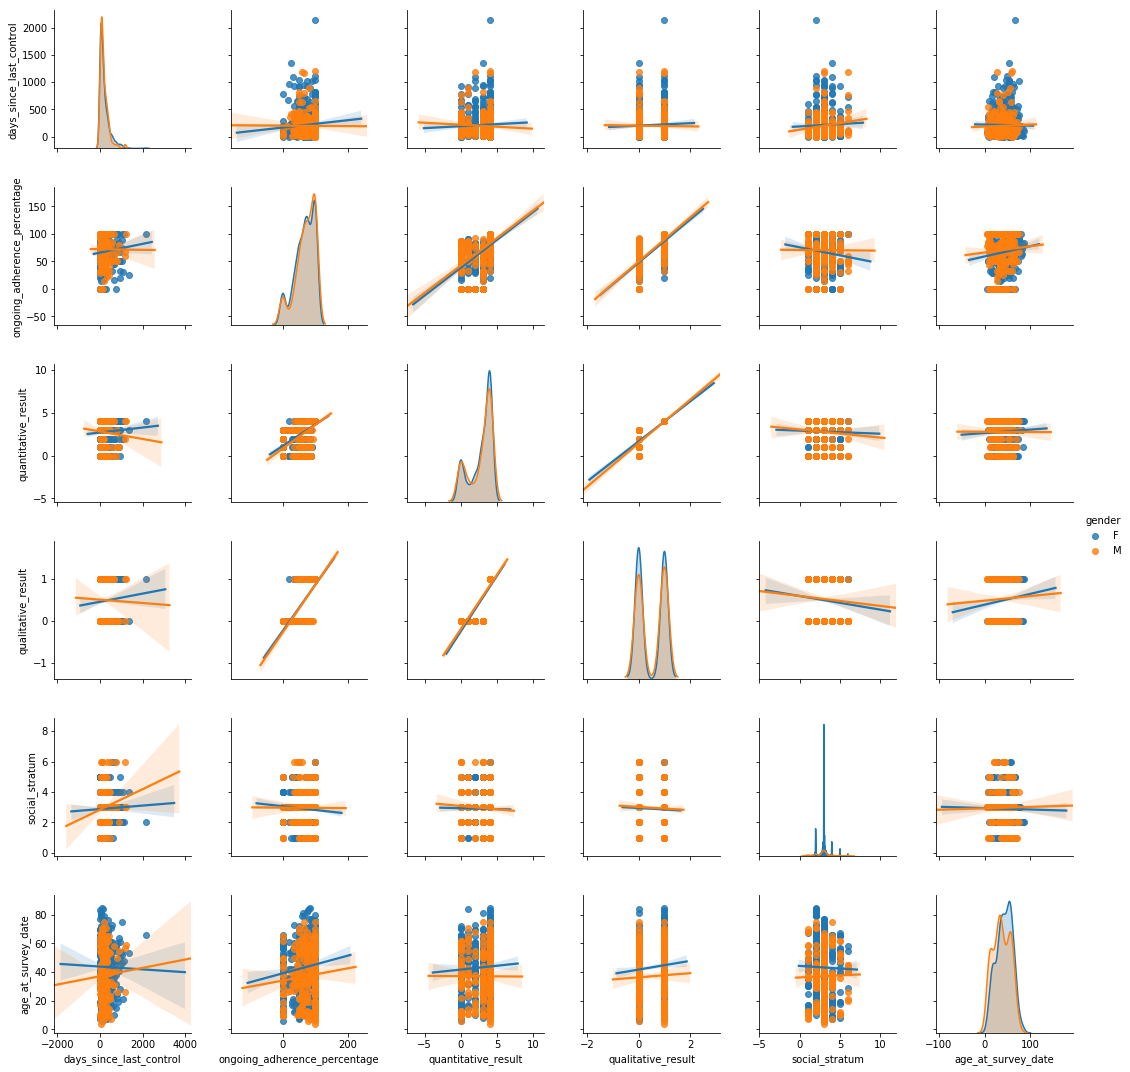

In [77]:
select_vars=['days_since_last_control', 'ongoing_adherence_percentage', 'quantitative_result', 'qualitative_result', 'social_stratum', 'age_at_survey_date']
sns.pairplot(balanced_sample, vars=select_vars, hue='gender', kind='reg')

In [78]:
balanced_sample.dtypes

id_patient                                   int64
survey_date                         datetime64[ns]
category                                  category
qualitative_result                           int64
quantitative_result                          int64
qualitative_result_change                  float64
quantitative_result_change                 float64
days_since_last_control                    float64
ongoing_adherence_percentage               float64
num_reports                                  int64
age                                        float64
gender                                    category
education                                 category
civil_status                              category
department                                  object
city                                        object
social_stratum                             float64
zone                                      category
socioeconomic_level                       category
occupation                     

In [79]:
basic_info_adherence['social_security_regime'].cat.categories

Index(['CONTRIBUTIVO', 'OTRO', 'PARTICULAR', 'SUBSIDIADO'], dtype='object')

# Adherencia vs Escolaridad

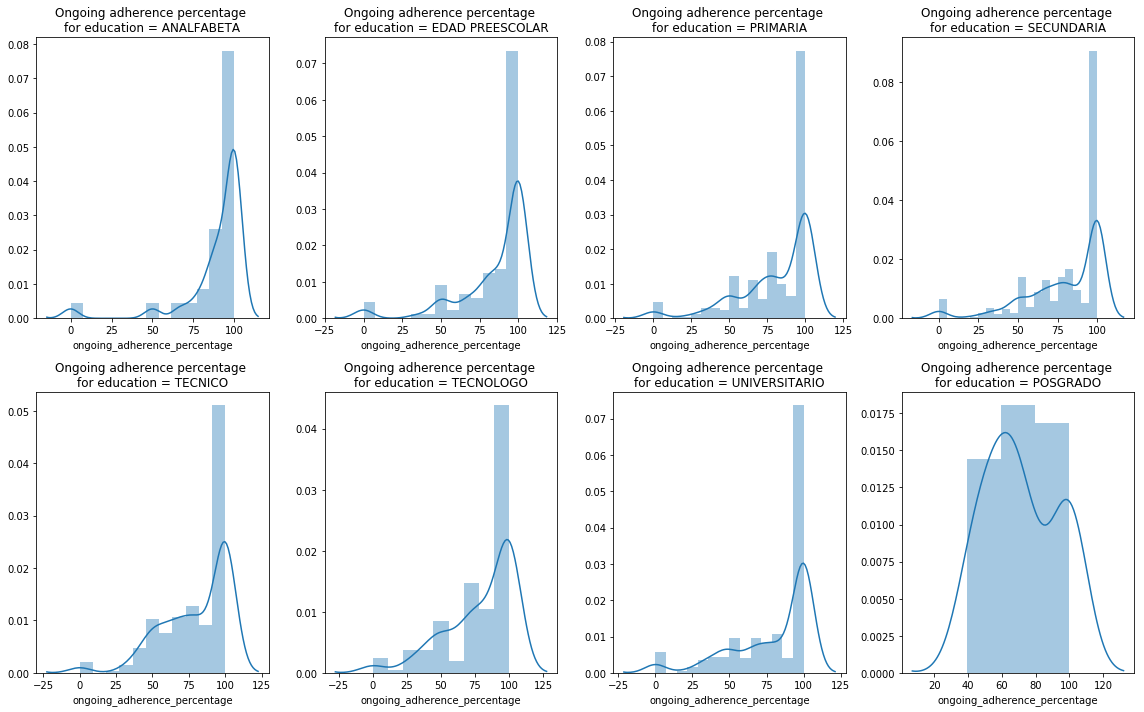

In [86]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['education'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['education'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor education = " + str(level));

plt.tight_layout()

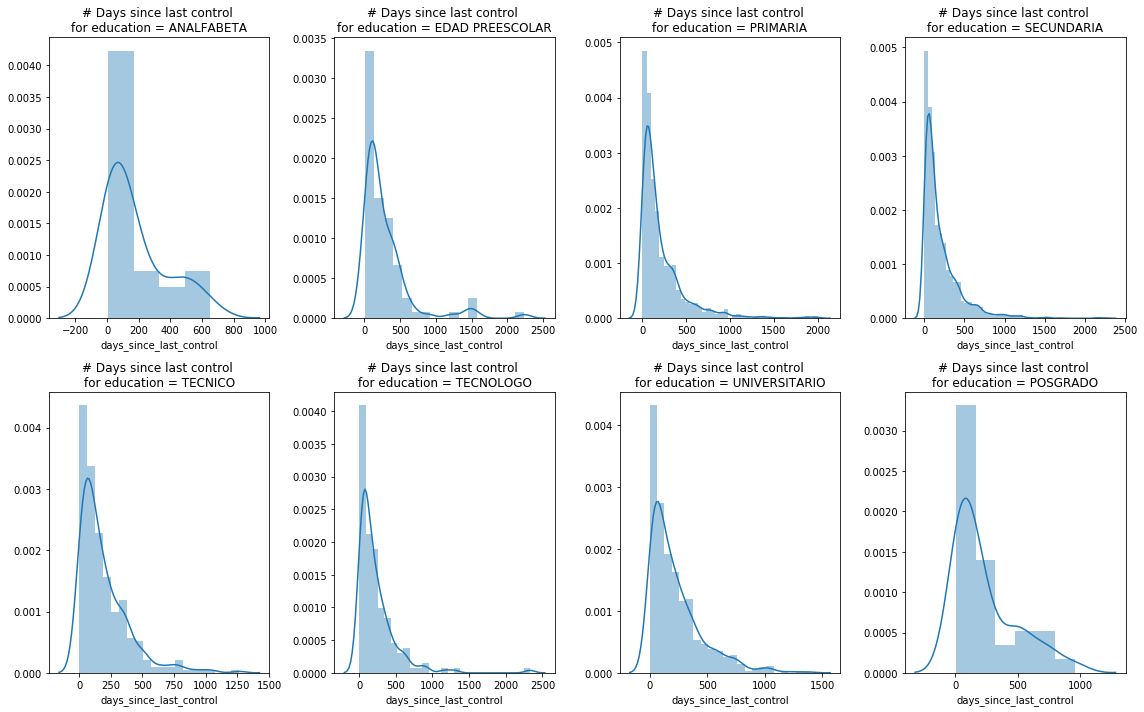

In [87]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['education'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['education'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor education = " + str(level));

plt.tight_layout()

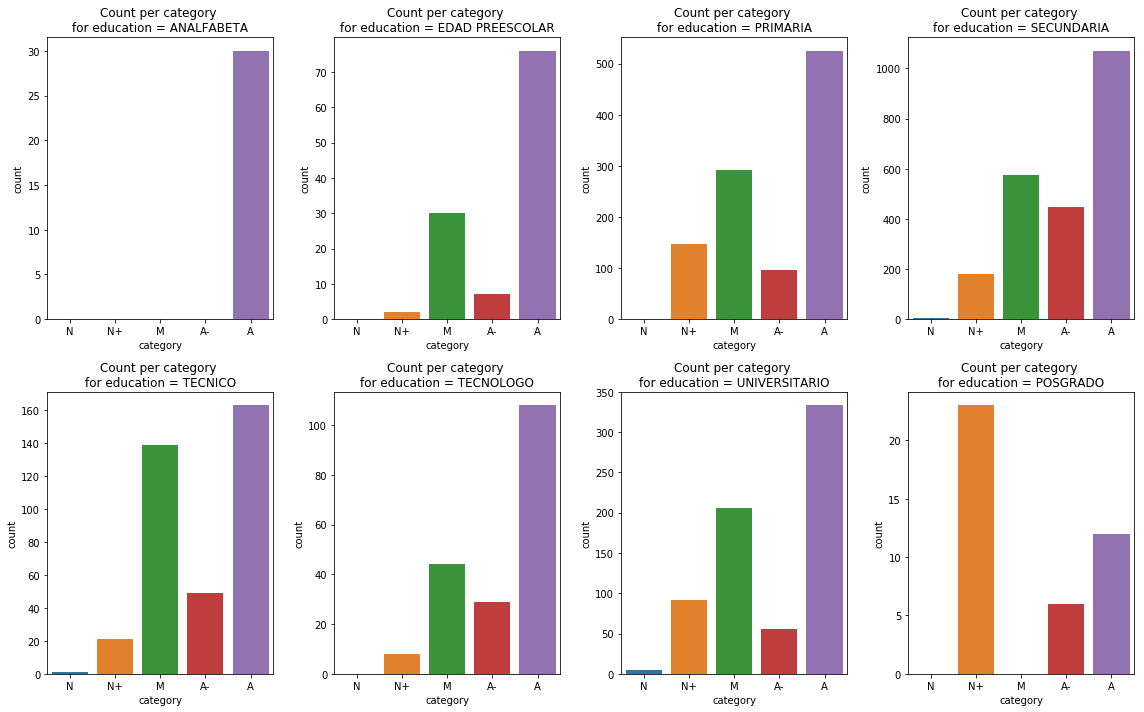

In [88]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['education'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['education'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor education = " + str(level));

plt.tight_layout()

# Adherencia vs Zona (Urbana/Rural)

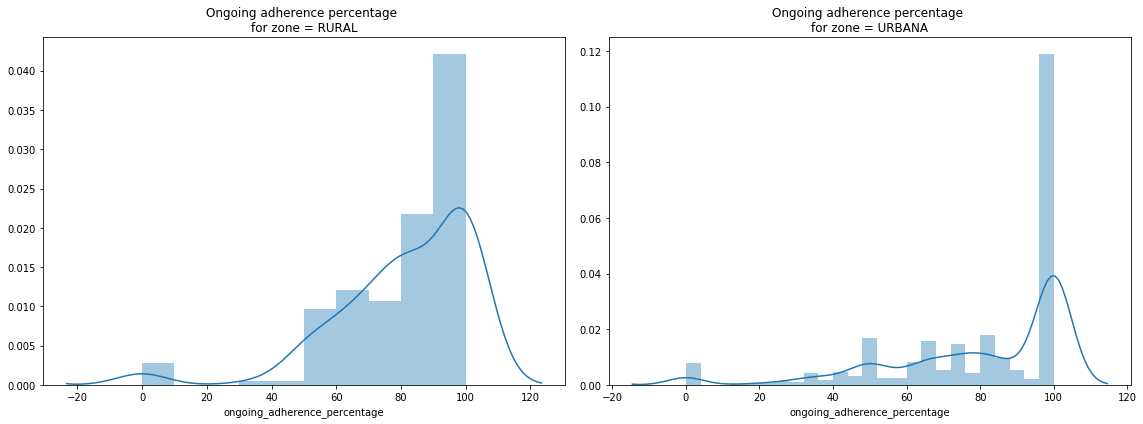

In [89]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zone'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['zone'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor zone = " + str(level));

plt.tight_layout()

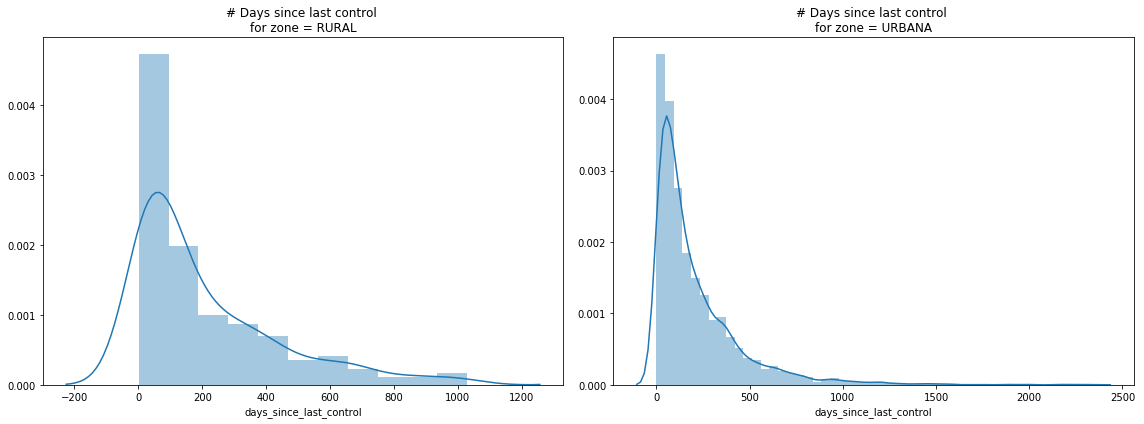

In [90]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zone'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['zone'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor zone = " + str(level));

plt.tight_layout()

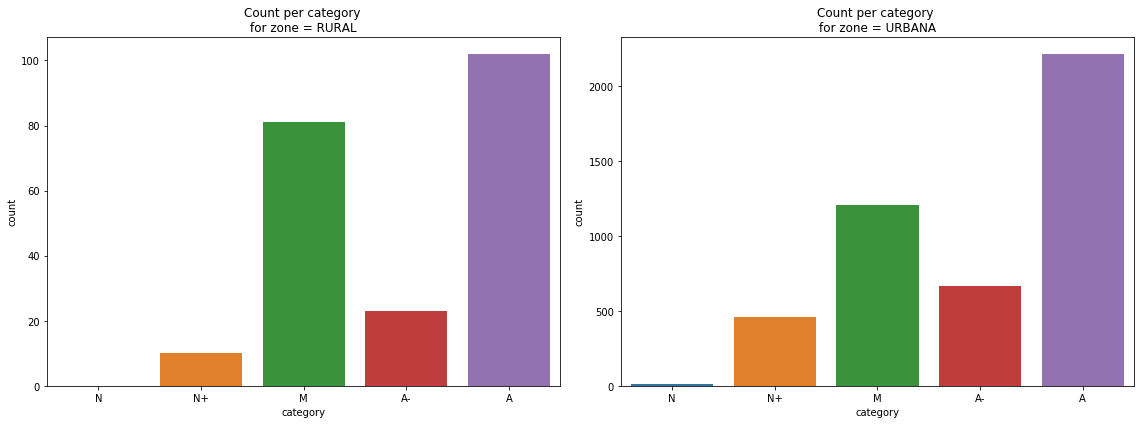

In [91]:
plt.figure(figsize=(16,6))

for i, level in enumerate(basic_info_adherence['zone'].cat.categories):
    plt.subplot(1,2,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['zone'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor zone = " + str(level));

plt.tight_layout()

# Adherencia vs Nivel socioeconomico

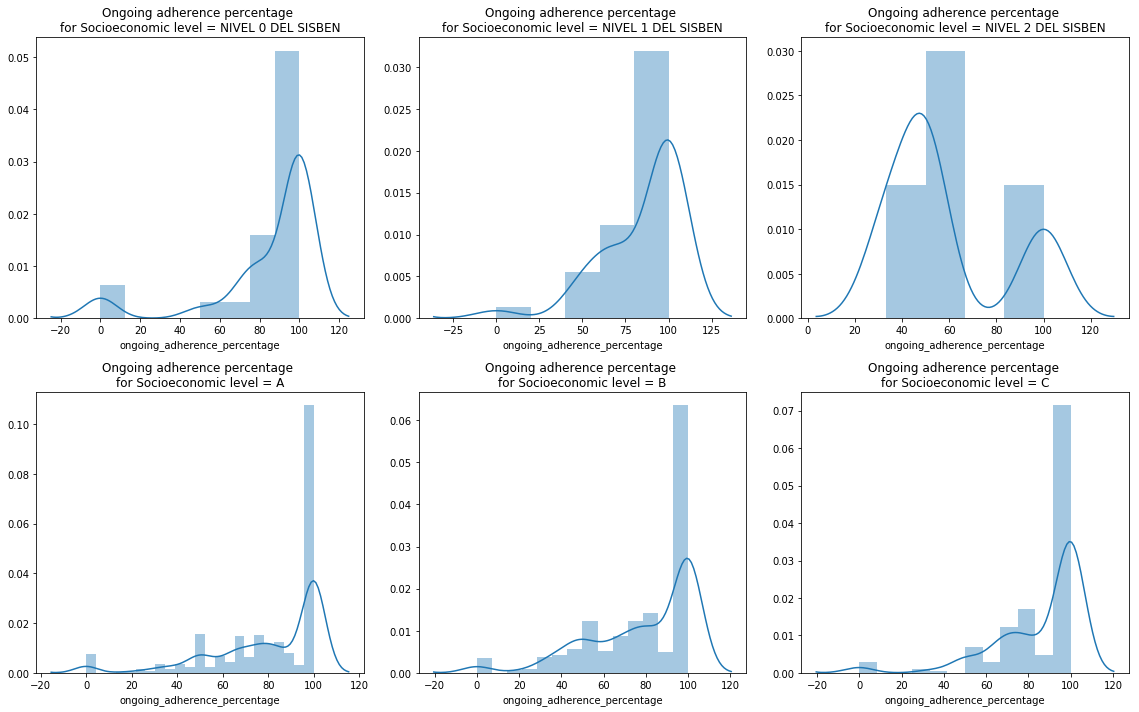

In [92]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['socioeconomic_level'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['socioeconomic_level'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor Socioeconomic level = " + str(level));

plt.tight_layout()

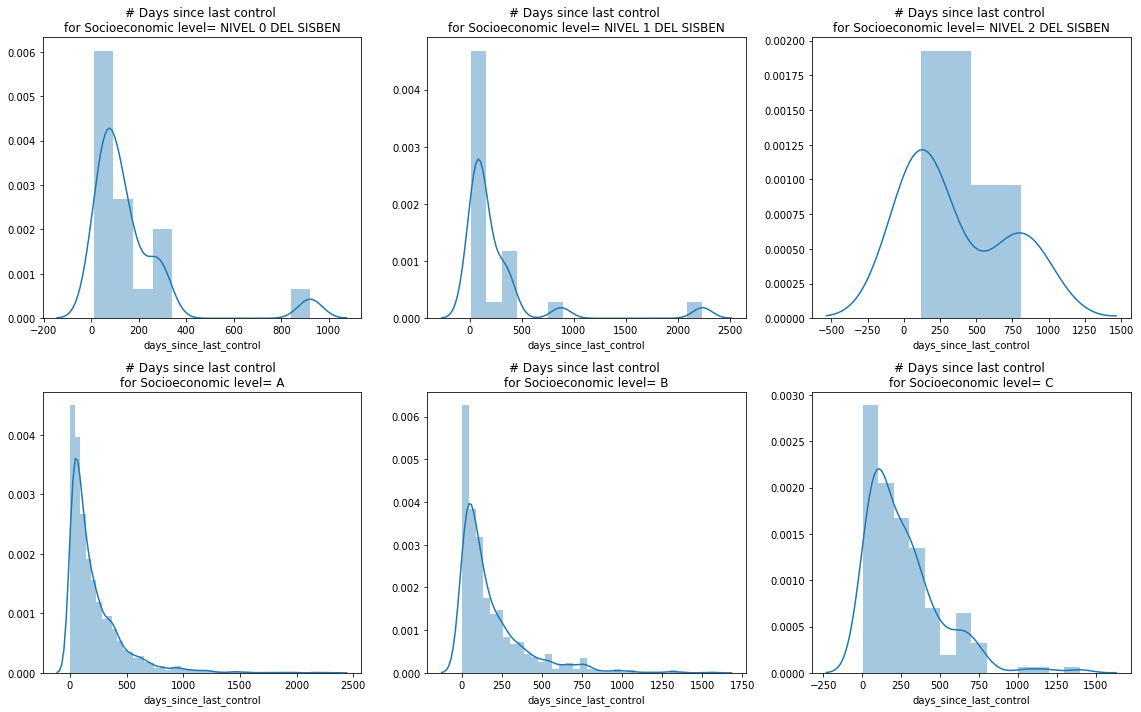

In [93]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['socioeconomic_level'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['socioeconomic_level'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor Socioeconomic level= " + str(level));

plt.tight_layout()

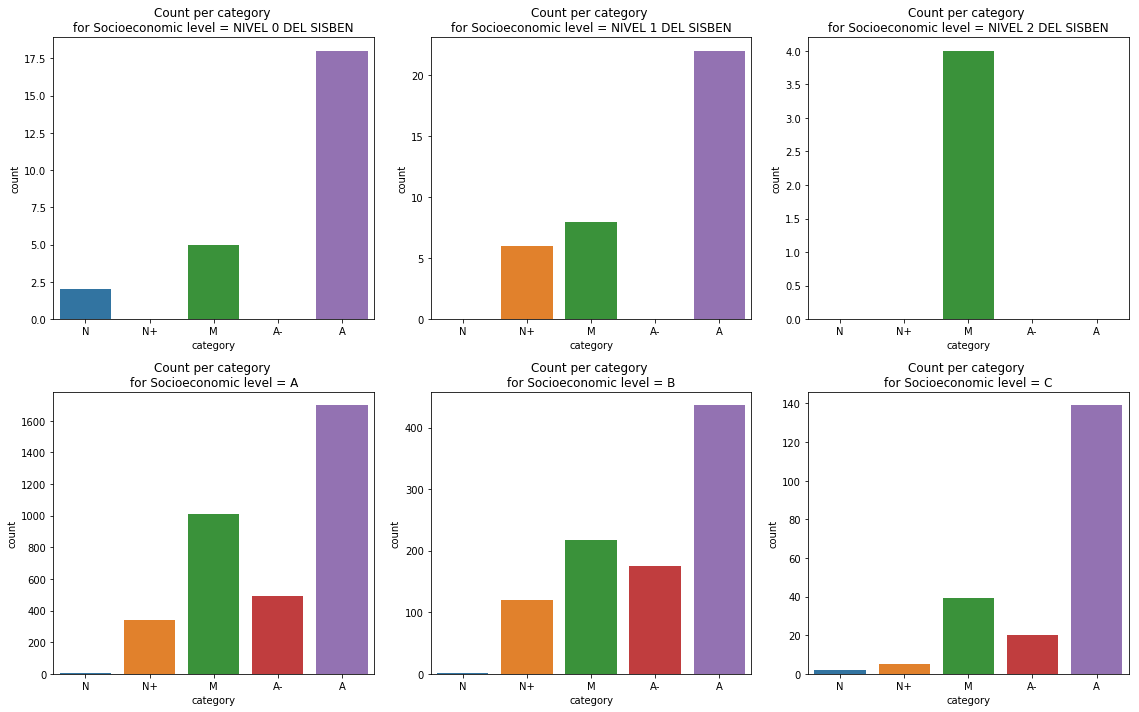

In [94]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['socioeconomic_level'].cat.categories):
    plt.subplot(2,3,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['socioeconomic_level'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor Socioeconomic level = " + str(level));

plt.tight_layout()

# Adherencia vs Ocupacion

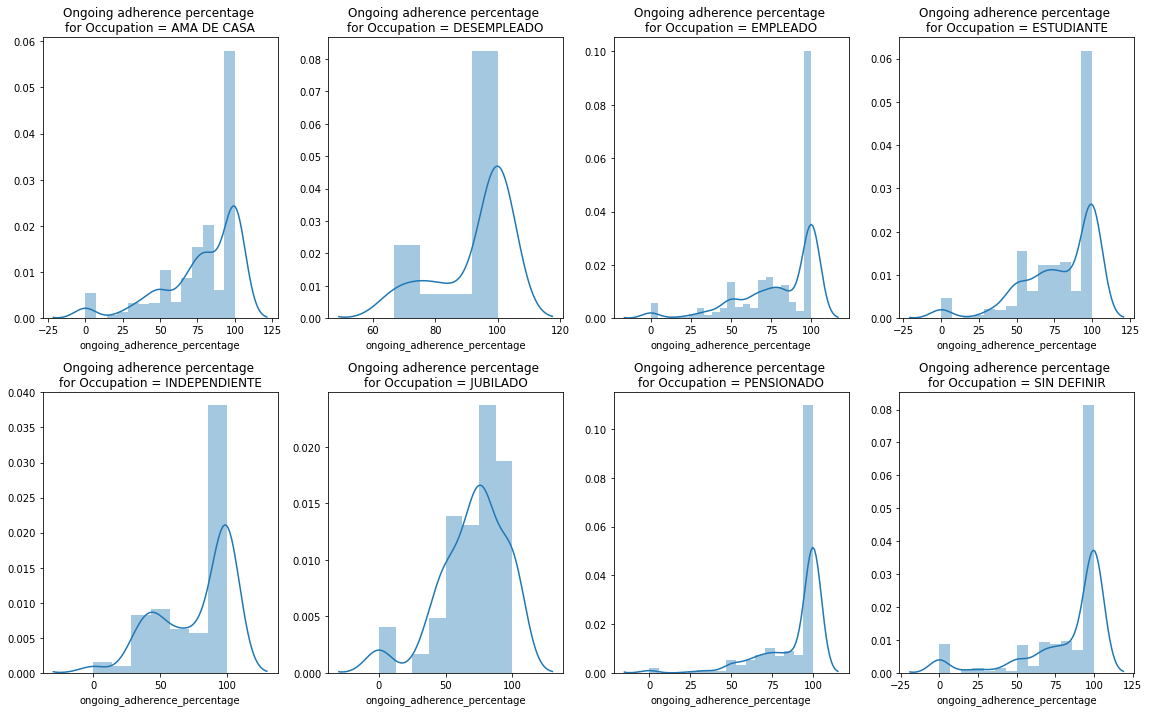

In [95]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['occupation'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['occupation'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor Occupation = " + str(level));

plt.tight_layout()

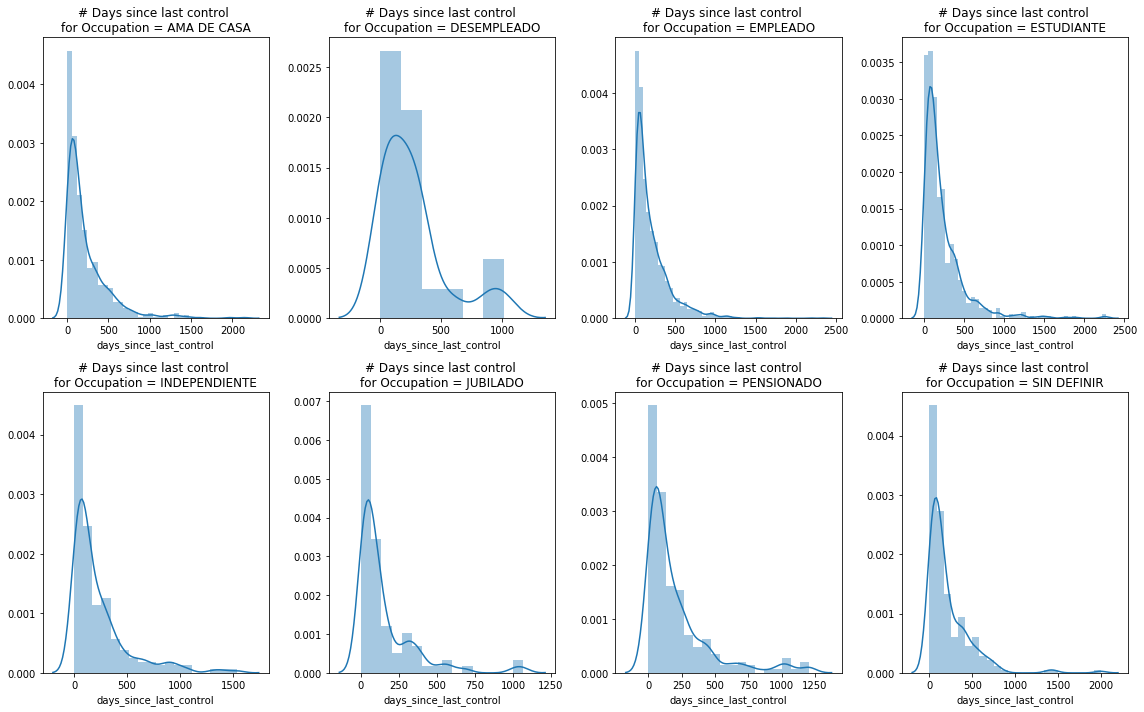

In [96]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['occupation'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['occupation'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor Occupation = " + str(level));

plt.tight_layout()

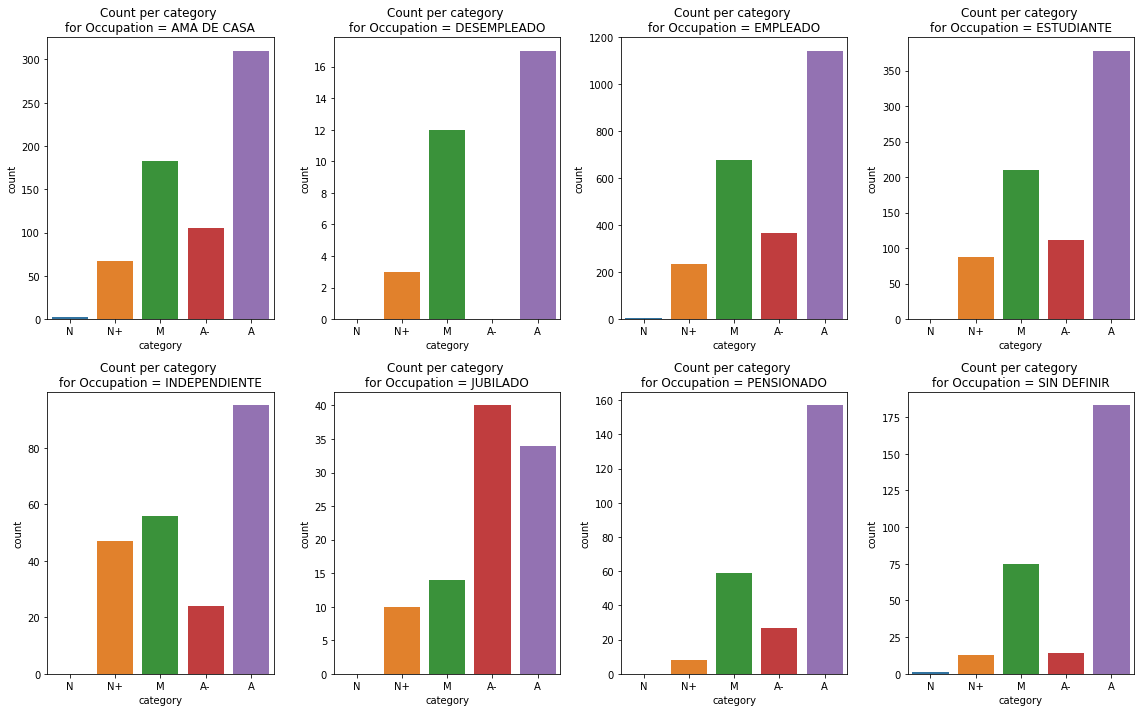

In [97]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['occupation'].cat.categories):
    plt.subplot(2,4,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['occupation'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor Occupation = " + str(level));

plt.tight_layout()

# Adherencia vs Regimen

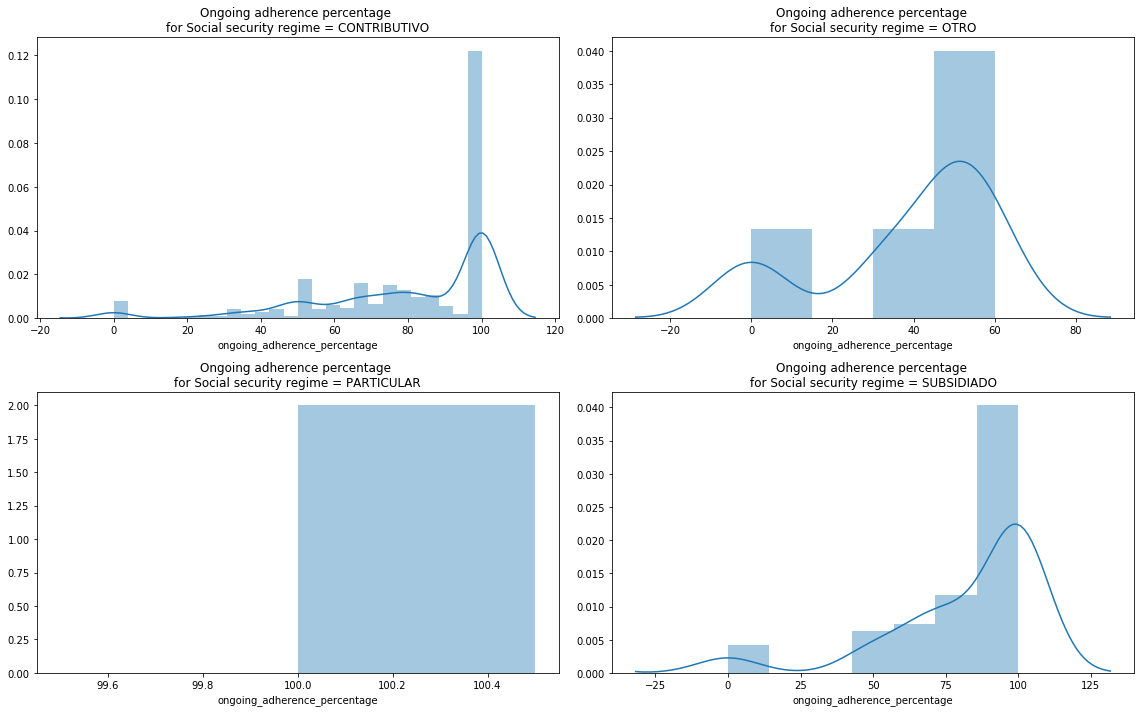

In [98]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['social_security_regime'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['social_security_regime'] == level),'ongoing_adherence_percentage'], label=level)
    plt.title("Ongoing adherence percentage \nfor Social security regime = " + str(level));

plt.tight_layout()

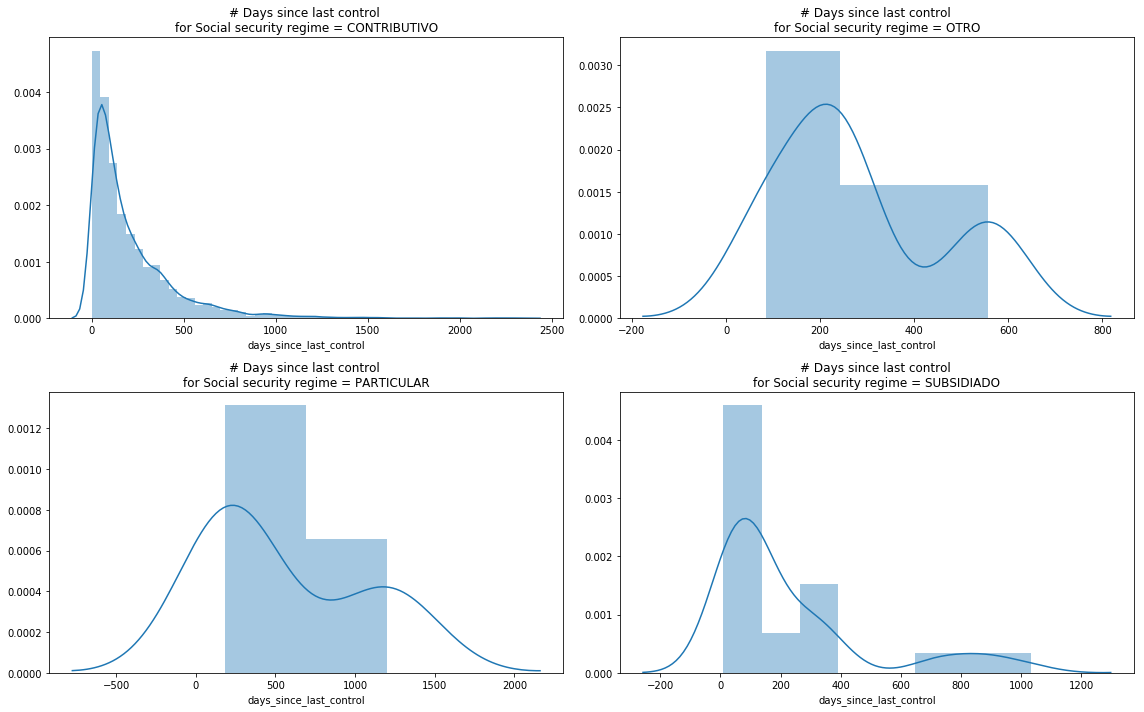

In [99]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['social_security_regime'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.distplot(basic_info_adherence.loc[(basic_info_adherence['social_security_regime'] == level),'days_since_last_control'].dropna(), label=level)
    plt.title("# Days since last control \nfor Social security regime = " + str(level));

plt.tight_layout()

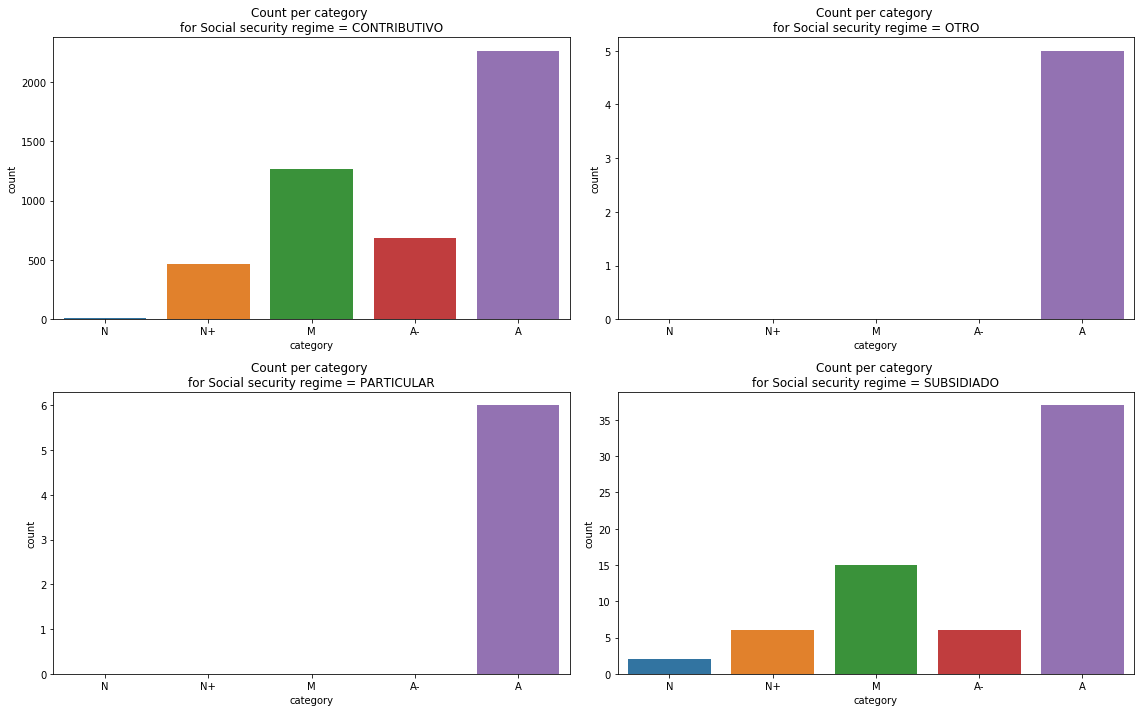

In [100]:
plt.figure(figsize=(16,10))

for i, level in enumerate(basic_info_adherence['social_security_regime'].cat.categories):
    plt.subplot(2,2,i+1)
    sns.barplot(data=basic_info_adherence[(basic_info_adherence['social_security_regime'] == level)].groupby('category').size().reset_index(name='count'), x='category', y='count', label=level)
    plt.title("Count per category \nfor Social security regime = " + str(level));

plt.tight_layout()

# Edad entrevista vs Porcentaje historico adherencia

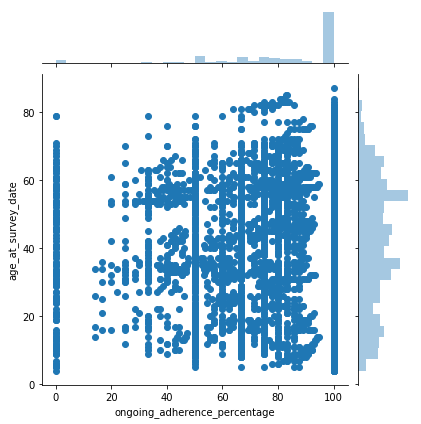

In [101]:
ax = sns.jointplot("ongoing_adherence_percentage", "age_at_survey_date", data=basic_info_adherence)

In [102]:
basic_info_non_adherent_patients.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,...,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_group,age_at_survey_date
8,502989,2014-08-22,M,0,2,NaN,NaN,NaN,0.00,1,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
9,502989,2014-10-28,M,0,2,0.0,0.0,67.0,0.00,2,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
11,502989,2015-01-07,M,0,3,0.0,-1.0,47.0,0.00,4,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
12,502989,2015-01-14,M,0,3,0.0,0.0,7.0,0.00,5,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,25
14,502989,2016-01-12,M,0,3,-1.0,-1.0,201.0,14.29,7,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,26
16,502989,2017-01-03,M,0,3,-1.0,-1.0,354.0,22.22,9,...,3.0,URBANA,A,SIN DEFINIR,CONTRIBUTIVO,BENEFICIARIO,SIN EMPLEO,1990-08-22,3.0,27
36,506808,2019-02-21,M,0,0,0.0,-4.0,136.0,80.00,15,...,1.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,2008-10-06,2.0,11
48,512938,2019-09-30,M,0,1,-1.0,-3.0,293.0,72.73,11,...,3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1997-10-15,3.0,22
62,524006,2017-05-10,A-,0,3,-1.0,-1.0,28.0,70.00,10,...,3.0,URBANA,A,PENSIONADO,CONTRIBUTIVO,COTIZANTE,PENSIONADO,1952-08-10,7.0,65
94,529410,2019-02-14,A-,0,3,0.0,-1.0,380.0,57.14,7,...,3.0,RURAL,A,ESTUDIANTE,CONTRIBUTIVO,BENEFICIARIO,MENOR NO LABORA,1998-01-21,3.0,22


Text(0.5,0,'Social stratum classification')

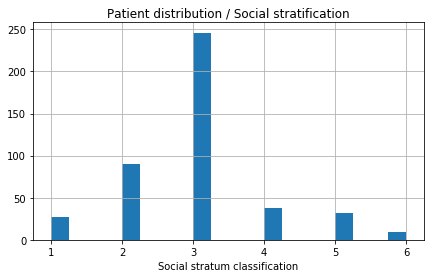

In [103]:
plt.figure(figsize=(7,4))
basic_info_non_adherent_patients['social_stratum'].hist(bins=20)
plt.title("Patient distribution / Social stratification")
plt.xlabel("Social stratum classification")

In [104]:
count_per_depto = basic_info_non_adherent_patients[['id_patient', 'department']].groupby('department').count().reset_index()
count_per_depto.columns = ['department', 'count_patients']
count_per_depto['percentage'] = (count_per_depto['count_patients'] / sum(count_per_depto['count_patients']))*100
count_per_depto.sort_values(by='count_patients', ascending=False).set_index('department')

,count_patients,percentage
department,,
ANTIOQUIA,407,92.081448
ATLANTICO,13,2.941176
VALLE DEL CAUCA,9,2.036199
CUNDINAMARCA,8,1.809955
CALDAS,5,1.131222


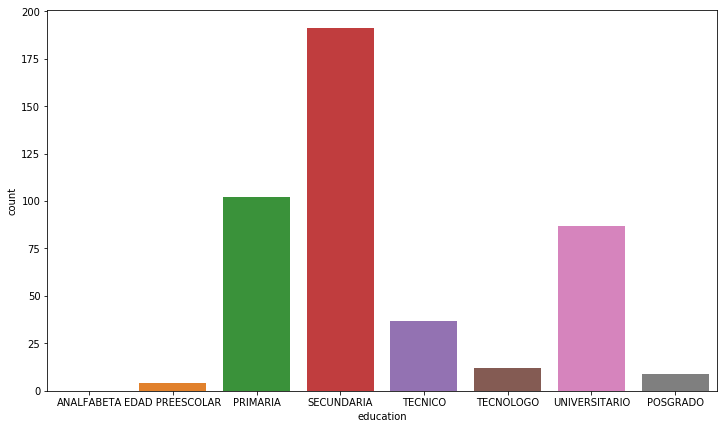

In [105]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('education').size().reset_index(name='count'), x='education', y='count', ax=ax)

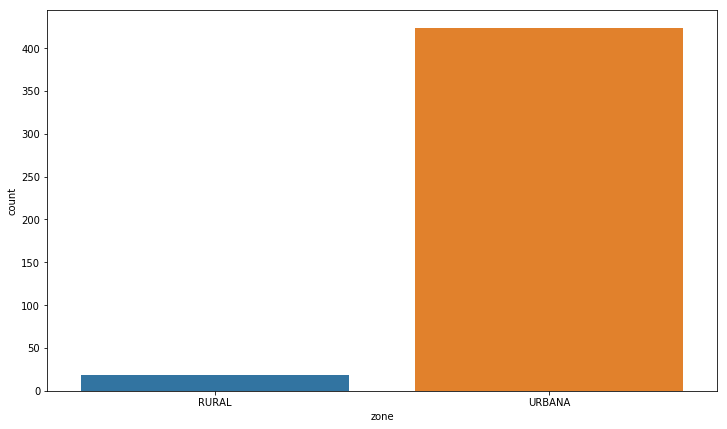

In [106]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('zone').size().reset_index(name='count'), x='zone', y='count', ax=ax)

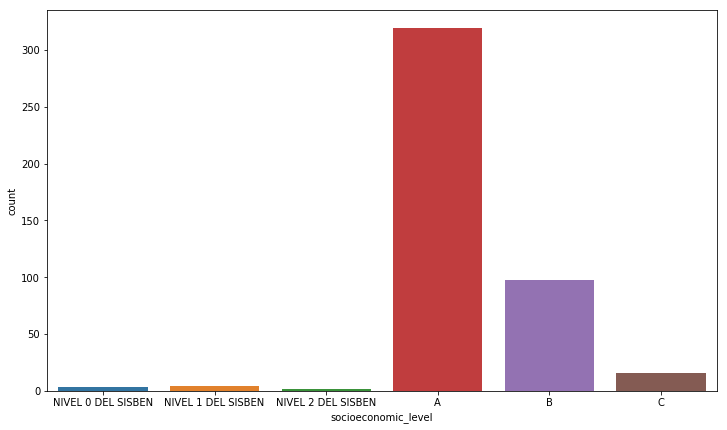

In [107]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('socioeconomic_level').size().reset_index(name='count'), x='socioeconomic_level', y='count', ax=ax)

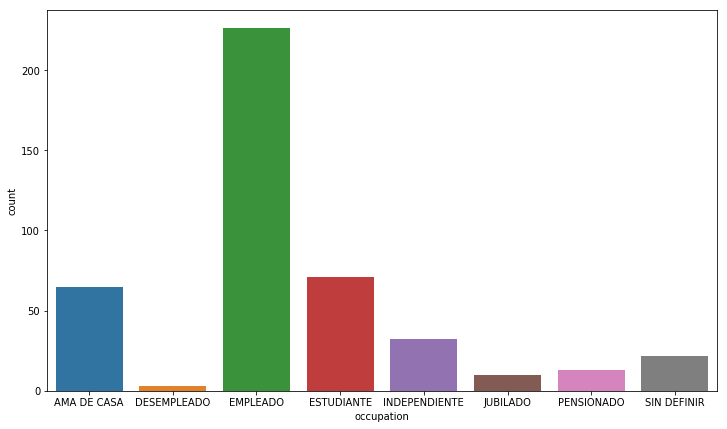

In [108]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('occupation').size().reset_index(name='count'), x='occupation', y='count', ax=ax)

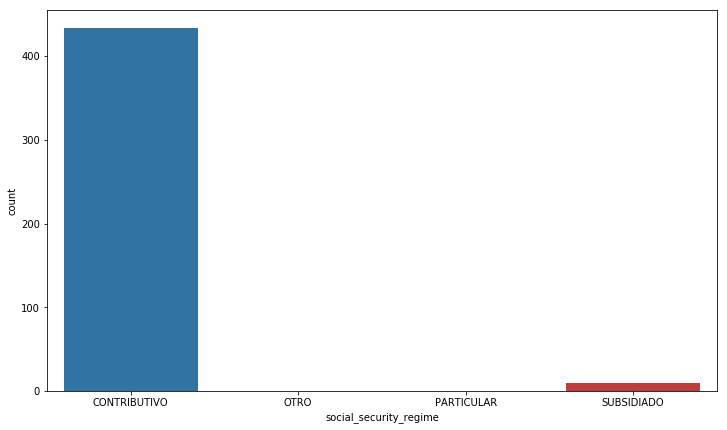

In [109]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=basic_info_non_adherent_patients.groupby('social_security_regime').size().reset_index(name='count'), x='social_security_regime', y='count', ax=ax)

Text(0.5,0,'Age')

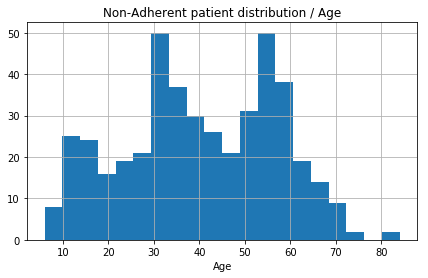

In [111]:
plt.figure(figsize=(7,4))
basic_info_non_adherent_patients['age_at_survey_date'].hist(bins=20)
plt.title("Non-Adherent patient distribution / Age")
plt.xlabel("Age")

# Frequency analysis

In [112]:
corr_adherence = adherence_change_analysis.corr()

Text(0.5,1,'Correlation Matrix')

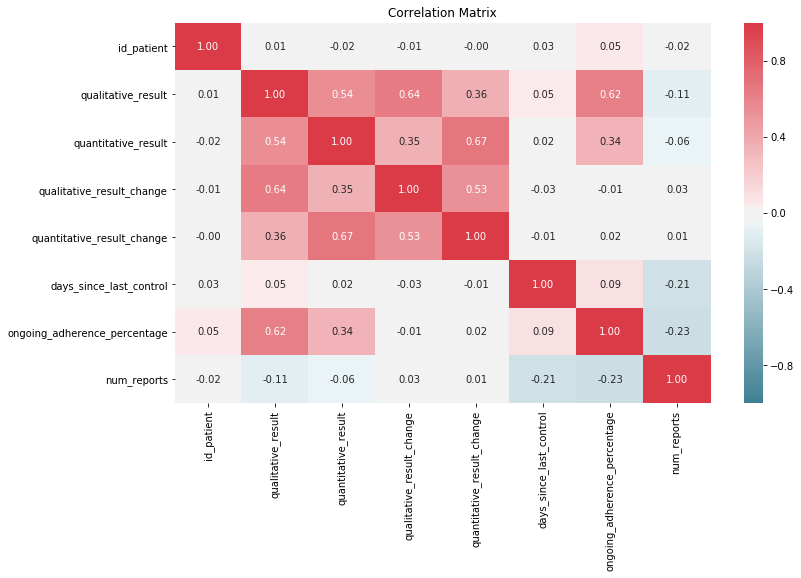

In [113]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_adherence, annot=True, fmt=".2f", ax=ax, center=0, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

How often a patient goes from non-adherent to adherent:

$P_{AdherentTransition} = \frac{\|PositiveTransitions\|}{\|PositiveTransitions\| + \|NoTransition|_{NonAdherent}\|}$

$P_{StayNonAdherent} = 1-P_{AdherentTransition}$

$P_{NonAdherentTransition} = \frac{\|NegativeTransitions\|}{\|NegativeTransitions\| + \|NoTransition|_{Adherent}\|}$

$P_{StayAdherent} = 1-P_{NonAdherentTransition}$

$P_{Transition} = \frac{\|PositiveTransitions\|+\|NegativeTransitions\|}{\|PositiveTransitions\| + \|NoTransition|_{NonAdherent}\| + \|NegativeTransitions\| + \|NoTransition|_{Adherent}\|}$

$P_{StayUnchanged} = 1-P_{Transition}$

In [116]:
num_pos_transitions = len(pos_transition)
num_neg_transitions = len(neg_transition)
num_no_trans_no_adherent = len(adherence_change_analysis[(adherence_change_analysis['qualitative_result'] == 0) & (adherence_change_analysis['qualitative_result_change'] == 0)])
num_no_trans_adherent = len(adherence_change_analysis[(adherence_change_analysis['qualitative_result'] == 1) & (adherence_change_analysis['qualitative_result_change'] == 0)])

In [117]:
pat_full_data = num_pos_transitions / (num_pos_transitions + num_no_trans_no_adherent)
print(f'Probability of a patient going from Non-adherent to Adherent: {round(pat_full_data, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat_full_data, 2)}')

Probability of a patient going from Non-adherent to Adherent: 0.65
Probability of a patient staying non-adherent: 0.35


In [118]:
pnt_full_data = num_neg_transitions / (num_neg_transitions + num_no_trans_adherent)
print(f'Probability of a patient going from Adherent to Non-adherent: {round(pnt_full_data, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt_full_data, 2)}')

Probability of a patient going from Adherent to Non-adherent: 0.19
Probability of a patient staying Adherent: 0.81


In [119]:
pt_full_data = (num_pos_transitions + num_neg_transitions) / (num_neg_transitions + num_no_trans_adherent + num_pos_transitions + num_no_trans_no_adherent)
print(f'Probability of a patient transitioning (NA -> A or A -> NA): {round(pt_full_data, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt_full_data, 2)}')

Probability of a patient transitioning (NA -> A or A -> NA): 0.29
Probability of a patient remaining unchaged: 0.71


## Analysis according to demographic variables:

In [121]:
vbles = ['gender', 'education', 'zone', 'socioeconomic_level', 'occupation', 'employment_type']

def estimate_probabilities4variable(df, variable):
    print('***********************************************************************')
    print(f'Probabilities for vble={variable}')
    print('---------------------------------')
    for val in df[variable].cat.categories:
        print(f'{variable}={val}:')
        num_pos_transitions = len(df[(df[variable]==val) & (df['qualitative_result_change']==1)])
        num_neg_transitions = len(df[(df[variable]==val) & (df['qualitative_result_change']==-1)])
        num_no_trans_no_adherent = len(df[(df[variable]==val) & (df['qualitative_result'] == 0) & (df['qualitative_result_change'] == 0)])
        num_no_trans_adherent = len(df[(df[variable]==val) & (df['qualitative_result'] == 1) & (df['qualitative_result_change'] == 0)])
        pat_full_data = num_pos_transitions / (num_pos_transitions + num_no_trans_no_adherent)
        print(f'Probability of a patient going from Non-adherent to Adherent: {round(pat_full_data, 2)}')
        print(f'Probability of a patient staying non-adherent: {round(1-pat_full_data, 2)}')
        print('-----------------------------------------------------------------------')
        pnt_full_data = num_neg_transitions / (num_neg_transitions + num_no_trans_adherent)
        print(f'Probability of a patient going from Adherent to Non-adherent: {round(pnt_full_data, 2)}')
        print(f'Probability of a patient staying Adherent: {round(1-pnt_full_data, 2)}')
        print('-----------------------------------------------------------------------')
        pt_full_data = (num_pos_transitions + num_neg_transitions) / (num_neg_transitions + num_no_trans_adherent + num_pos_transitions + num_no_trans_no_adherent)
        print(f'Probability of a patient transitioning (NA -> A or A -> NA): {round(pt_full_data, 2)}')
        print(f'Probability of a patient remaining unchaged: {round(1-pt_full_data, 2)}')
        print('-----------------------------------------------------------------------')
        
for vble in vbles:
    estimate_probabilities4variable(basic_info_adherence, vble)

***********************************************************************
Probabilities for vble=gender
---------------------------------
gender=F:
Probability of a patient going from Non-adherent to Adherent: 0.65
Probability of a patient staying non-adherent: 0.35
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.19
Probability of a patient staying Adherent: 0.81
-----------------------------------------------------------------------
Probability of a patient transitioning (NA -> A or A -> NA): 0.29
Probability of a patient remaining unchaged: 0.71
-----------------------------------------------------------------------
gender=M:
Probability of a patient going from Non-adherent to Adherent: 0.66
Probability of a patient staying non-adherent: 0.34
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.18
Probability of a pat

Probability of a patient going from Non-adherent to Adherent: 1.0
Probability of a patient staying non-adherent: 0.0
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.22
Probability of a patient staying Adherent: 0.78
-----------------------------------------------------------------------
Probability of a patient transitioning (NA -> A or A -> NA): 0.39
Probability of a patient remaining unchaged: 0.61
-----------------------------------------------------------------------
socioeconomic_level=NIVEL 2 DEL SISBEN:
Probability of a patient going from Non-adherent to Adherent: 0.5
Probability of a patient staying non-adherent: 0.5
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 1.0
Probability of a patient staying Adherent: 0.0
-----------------------------------------------------------------------
Probability of a patie

Probability of a patient going from Non-adherent to Adherent: 0.63
Probability of a patient staying non-adherent: 0.37
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.2
Probability of a patient staying Adherent: 0.8
-----------------------------------------------------------------------
Probability of a patient transitioning (NA -> A or A -> NA): 0.3
Probability of a patient remaining unchaged: 0.7
-----------------------------------------------------------------------
employment_type=MENOR NO LABORA:
Probability of a patient going from Non-adherent to Adherent: 0.66
Probability of a patient staying non-adherent: 0.34
-----------------------------------------------------------------------
Probability of a patient going from Adherent to Non-adherent: 0.2
Probability of a patient staying Adherent: 0.8
-----------------------------------------------------------------------
Probability of a patient tran

In [122]:
basic_info_adherence.dtypes

id_patient                                   int64
survey_date                         datetime64[ns]
category                                  category
qualitative_result                           int64
quantitative_result                          int64
qualitative_result_change                  float64
quantitative_result_change                 float64
days_since_last_control                    float64
ongoing_adherence_percentage               float64
num_reports                                  int64
age                                        float64
gender                                    category
education                                 category
civil_status                              category
department                                  object
city                                        object
social_stratum                             float64
zone                                      category
socioeconomic_level                       category
occupation                     

### AGE